## Importing libraries

In [400]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
import matplotlib.pyplot as plt # to make good visualizations
import seaborn as sns # to make good visualizations
import random


## Reading datasets previously created

In [401]:
df_names = ['All', 'Top25', 'Top50', 'Top75', 'Side25', 'Side50', 'Side75']

In [402]:
all_predictions_df = pd.read_csv('./data/yolo_prediction/All.csv')
all_anns_df = pd.read_csv('./data/coco_diff/All.csv')

In [403]:
all_anns_df

Img  num_people    offset  face_avg_ratio  body_avg_ratio  \
0          36           1  0.294100        1.000000        1.000000   
1          49           6  0.363385        0.233333        0.291667   
2          61           3  0.130800        0.000000        0.000000   
3          74           6  0.340124        0.000000        0.000000   
4          77           5  0.382953        0.200000        0.550000   
...       ...         ...       ...             ...             ...   
58878  581886           3  0.357505        0.200000        0.666667   
58879  581887           1  0.690295        0.500000        0.250000   
58880  581899           3  0.115953        0.133333        0.000000   
58881  581900           6  0.510639        0.166667        0.375000   
58882  581921           1  0.333505        0.200000        0.750000   

       extremities_avg_ratio  num_people_diff  people_size_diff  \
0                   0.500000         0.500000          0.720162   
1                   0.187500         0.857143          0.996770   
2                   0.000000         0.750000          0.997873   
3                   0.000000         0.857143          0.998416   
4                   0.575000         0.833333          0.983026   
...                      ...              ...               ...   
58878               0.416667         0.750000          0.986880   
58879               0.000000         0.500000          0.990632   
58880               0.229167         0.750000          0.998169   
58881               0.364583         0.857143          0.985052   
58882               0.812500         0.500000          0.954253   

       visibility_diff  offset_diff  total_dif  
0             0.100000     0.294100   0.403566  
1             0.758333     0.363385   0.743908  
2             1.000000     0.130800   0.719668  
3             1.000000     0.340124   0.798921  
4             0.620000     0.382953   0.704828  
...                ...          ...        ...  
58878         0.616667     0.357505   0.677763  
58879         0.675000     0.690295   0.713982  
58880         0.887500     0.115953   0.687905  
58881         0.731250     0.510639   0.771021  
58882         0.512500     0.333505   0.575064  

[58883 rows x 11 columns]

In [404]:
all_predictions_df

ID  Img_ID  Confidence Format  x_center  y_center     width  \
0        3260     326    0.866764    rgb  0.519095  0.579268  0.565375   
1       11490    1149    0.881282    rgb  0.252400  0.301281  0.176131   
2       11491    1149    0.851260    rgb  0.927591  0.469189  0.143462   
3       11492    1149    0.804412    rgb  0.678745  0.470363  0.150654   
4       11493    1149    0.740676    rgb  0.845905  0.442369  0.101878   
...       ...     ...         ...    ...       ...       ...       ...   
5587  5811831  581183    0.793697    rgb  0.486329  0.759381  0.061583   
5588  5811832  581183    0.503064    rgb  0.249292  0.869054  0.111275   
5589  5811833  581183    0.321343    rgb  0.370138  0.217217  0.034143   
5590  5812780  581278    0.803501    rgb  0.462290  0.493127  0.642913   
5591  5815570  581557    0.801042    rgb  0.503194  0.499135  0.504543   

        height  
0     0.817304  
1     0.383411  
2     0.780830  
3     0.718626  
4     0.689938  
...        ...  
5587  0.286074  
5588  0.255515  
5589  0.138476  
5590  0.937107  
5591  0.967100  

[5592 rows x 8 columns]

<Axes: >

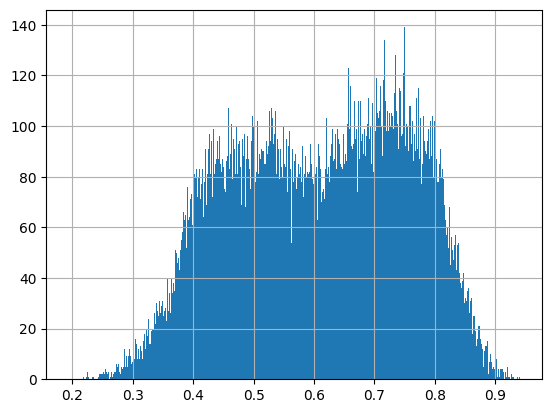

In [405]:
all_anns_df['total_dif'].hist(bins=1000)

Looking at the distribution, I can suggest four difficulty labels:
- Easy: images whose total_diff value is minor than 0.5
- Medium: images whose total_diff value is between 0.5 and 0.7
- Hard: images whose total_diff value is between 0.7 and 0.8
- Very Hard: images whose total_diff value is greater than 0.8

In [406]:
data = all_anns_df['total_dif'].sort_values()
easy = 0.5
medium = 0.7
hard = 0.8
easy_percent = float((data < easy).mean() * 100)
medium_percent = float(((data >= easy) & (data < medium)).mean() * 100)
hard_percent = float(((data >= medium) & (data < hard)).mean() * 100)
very_hard_percent = float((data >= hard).mean() * 100)

In [407]:
print(easy_percent)
print(medium_percent)
print(hard_percent)
print(very_hard_percent)

27.413684764702882
40.56688687736698
23.123821816143877
8.895606541786254


Here it's possible to see the percentiles the given value belong to. With this labeling we will have approximately the 27% of the data being considered as _easy_, 41% of the data considered as _medium_, 23% of the data considered as _hard_,  and 9% of the data being considered as _very hard_. 

In [408]:
def apply_total_dif_labeling(df, col):
    conditions = [
        (df[f'{col}'] < 0.4),
        (df[f'{col}'] > 0.85),
        (df[f'{col}'] > 0.6) & (df[f'{col}'] <= 0.85),
        (df[f'{col}'] >= 0.4) & (df[f'{col}'] <= 0.6)
    ]
    choices = ['easy', 'very hard', 'hard', 'medium']
    df['label'] = np.select(conditions, choices, default='unknown')
    return df

In [409]:
all_anns_df = apply_total_dif_labeling(all_anns_df, 'total_dif')

## Precision

I chose 0.50 as arbitrary value to consider a detection as confident enough to be evaluated. This value is low, taking a look at the distribution of confidence among all detections and at the confidence value of wrongly detected people, so we can consider this value as the borderline confidence the model has to make assumptions.

<Axes: >

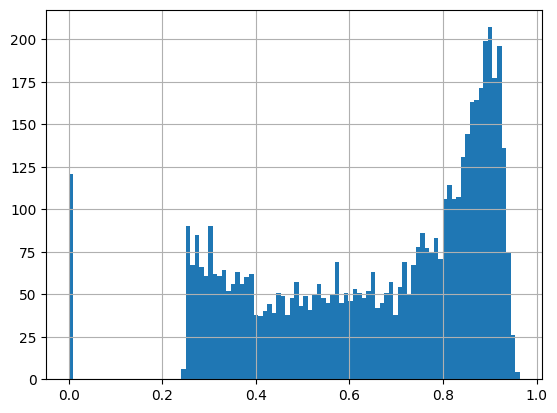

In [410]:
all_predictions_df['Confidence'].hist(bins=100)

In [411]:
def detect_on_threshold(df, threshold):
    df['detected'] = df['Confidence'].apply(lambda x: 1 if x>=threshold else 0)

In [412]:
detect_on_threshold(all_predictions_df, 0.5)

## Grouping

I grouped values based on Img_ID, aggregating confidence values with the mean and detected with the sum. In this way it is possible to have mean confidence and number of people detected in the image.

In [413]:
def group_predictions(df):
    return df.groupby('Img_ID').agg(
    {
        'Confidence': 'mean',
        'detected': 'sum',
        'Format': 'first'
    }
)

In [414]:
grouped_predictions_df = group_predictions(all_predictions_df)

In [415]:
df_out = pd.merge(all_anns_df, grouped_predictions_df, how='inner', left_on='Img', right_on='Img_ID')
df_out.set_index('Img', inplace=True)
df_pca = df_out.copy()
df_out = df_out[['Confidence', 'label', 'detected', 'num_people']]

I added 
- true positive values as the number of people detected correctly in the image
- false positive values as the number of people detected wrongly (the exceeding people detected)
- false negative values as the number of people not detected by the model

In [416]:
def adding_precision_feature(df):
    df.fillna({'detected': 0, 'Confidence': 0}, inplace=True)
    df['true_pos'] = np.minimum(df['detected'], df['num_people'])
    df['false_pos'] = np.maximum(df['detected'] - df['num_people'], 0)
    df['false_neg'] = np.maximum(df['num_people'] - df['detected'], 0)

Then I added some metrics to evaluate the model,
those are:
- accuracy, 1 for images where the detection has been perfect (number of people detected was the same as number of people in the image), 0 for the rest
- precision, as count of people well detected (who were in the image) over total of people detected, so how many detections were actually good over the total number of detection

- mae, mean absolute error (i.e. 3 for both 3 people detected in exceed or 3 people not detected)
- mse, mean squared error (to give more weight to very wrong detection)
- recall, number of well detected people over total number of people in the image
- f1-score, a combined version of both precision and recall

In [417]:
def adding_metrics_features(df):
    df['mae'] = np.abs(df['num_people']-df['detected'])
    df['mse'] = (df['num_people']-df['detected'])**2
    df['accuracy'] =(df['detected'] == df['num_people']).astype(int)
    df['precision'] = (df['true_pos']/(df['true_pos']+df['false_pos']))
    df['recall'] = (df['true_pos']/(df['true_pos']+df['false_neg']))
    df['f1-score'] = 2*((df['precision']*df['recall'])/(df['precision']+df['recall']))
    
    df.fillna({'precision': 0, 'recall': 0, 'f1-score': 0}, inplace=True)

In [418]:
adding_precision_feature(df_out)
adding_metrics_features(df_out)

In [419]:
df_out

Confidence   label  detected  num_people  true_pos  false_pos  \
Img                                                                     
326       0.866764  medium         1           1         1          0   
1149      0.607025    hard         9          12         9          0   
1200      0.739418    hard         3           3         3          0   
1319      0.431452  medium         0           1         0          0   
1900      0.000000    hard         0           1         0          0   
...            ...     ...       ...         ...       ...        ...   
579891    0.909920  medium         1           1         1          0   
580781    0.841013  medium         1           1         1          0   
581183    0.605279    hard         3          12         3          0   
581278    0.803501    easy         1           1         1          0   
581557    0.801042  medium         1           1         1          0   

        false_neg  mae  mse  accuracy  precision  recall  f1-score  
Img                                                                 
326             0    0    0         1        1.0    1.00  1.000000  
1149            3    3    9         0        1.0    0.75  0.857143  
1200            0    0    0         1        1.0    1.00  1.000000  
1319            1    1    1         0        0.0    0.00  0.000000  
1900            1    1    1         0        0.0    0.00  0.000000  
...           ...  ...  ...       ...        ...     ...       ...  
579891          0    0    0         1        1.0    1.00  1.000000  
580781          0    0    0         1        1.0    1.00  1.000000  
581183          9    9   81         0        1.0    0.25  0.400000  
581278          0    0    0         1        1.0    1.00  1.000000  
581557          0    0    0         1        1.0    1.00  1.000000  

[2001 rows x 13 columns]

### Plotting

In [420]:
def plot_grouped_boxplot(df, feature, name=None, subplot=None):
    if not subplot:
        plt.figure(figsize=(8, 6))
        
    custom_palette = {
        'easy': 'yellow',
        'medium': 'orange',
        'hard': 'red',
        'very hard': 'purple'
    }

    label_order = ['easy', 'medium', 'hard', 'very hard']


    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=custom_palette, dodge=False, legend=False, order=label_order)
    if name:
        plt.title(f"Boxplot of {feature} by Label - {name}")
    else:
        plt.title(f"Boxplot of {feature} by Label")
    plt.xlabel("Label")
    plt.ylabel(f"{feature}")

    if not subplot:
        plt.show()

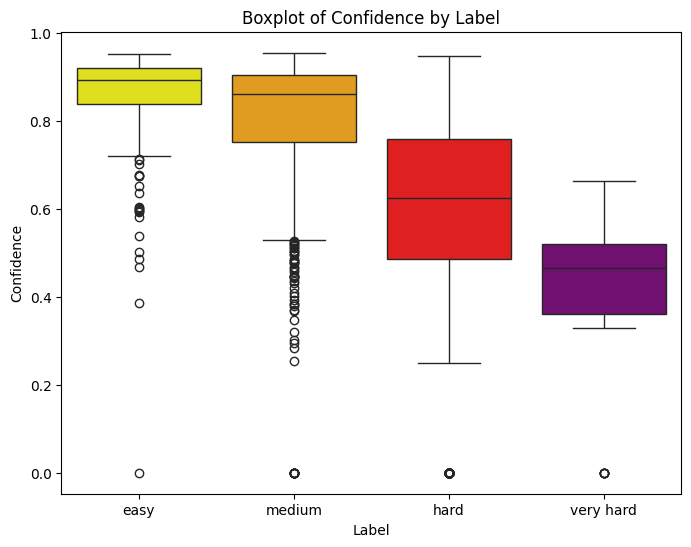

In [421]:
plot_grouped_boxplot(df_out, 'Confidence')

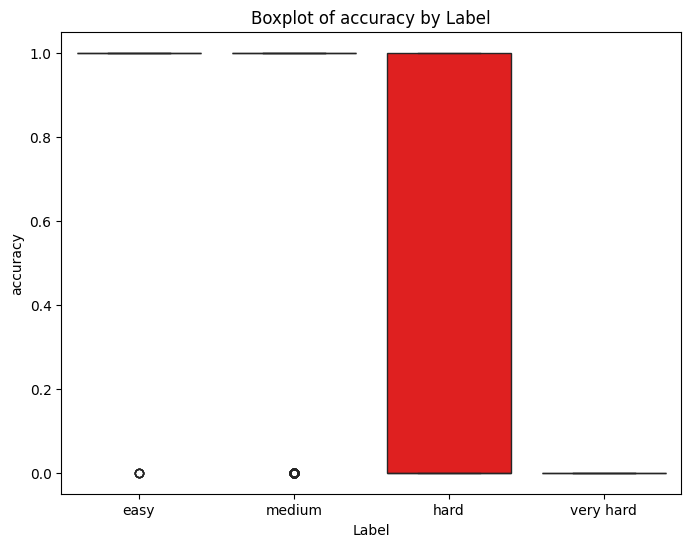

In [422]:
plot_grouped_boxplot(df_out, 'accuracy')

In [423]:
def group_df_and_agg_metrics(df):
    label_grouped = df.groupby('label').agg(
        {
            'mae': 'mean',
            'mse': 'mean',
            'accuracy': 'mean',
            'precision': 'mean'
        }
    )

    label_grouped['rmse'] = np.sqrt(label_grouped['mse'])
    return label_grouped

### Replicate for all other dataframes

--------------------
      All      
--------------------


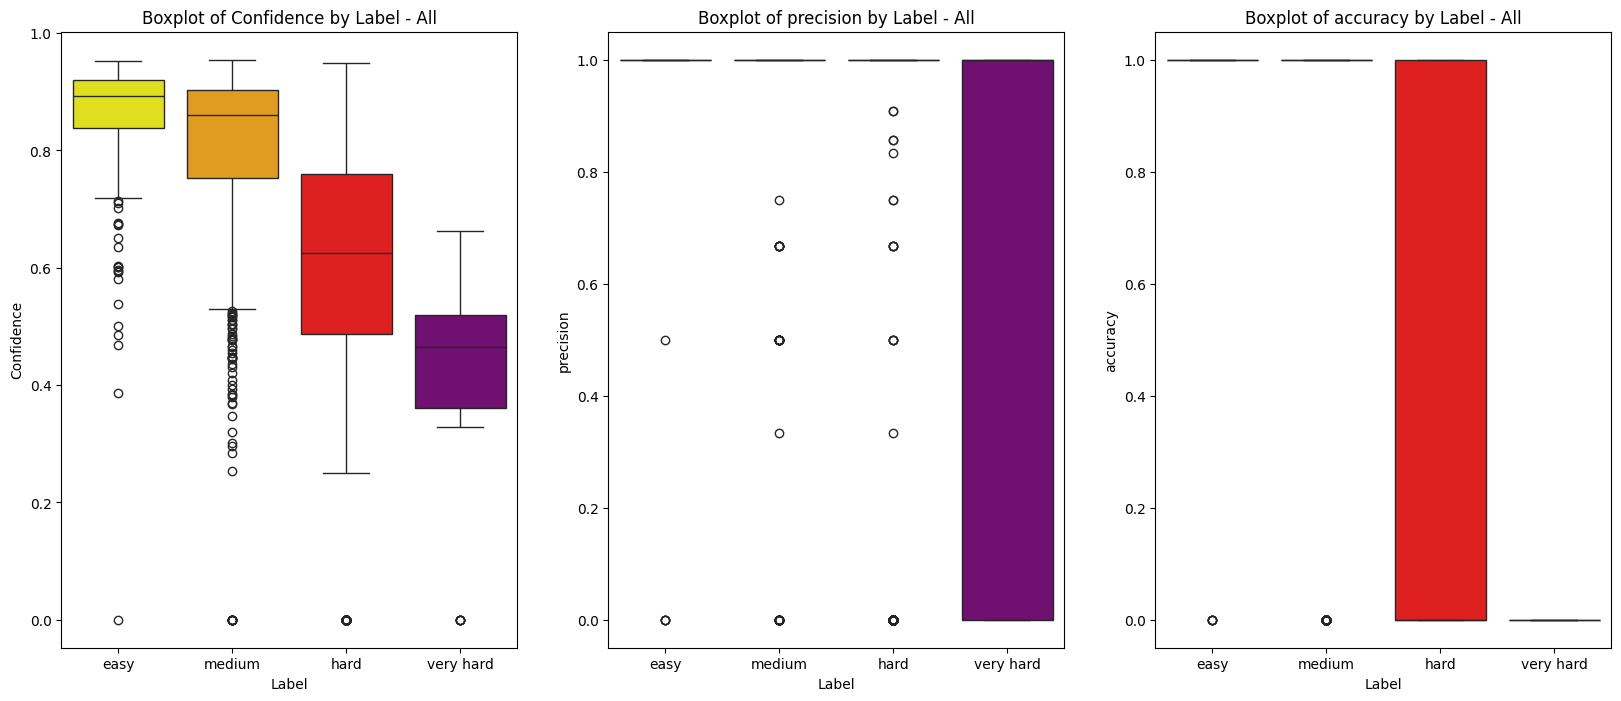

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.033113   0.033113  0.966887   0.970199  0.181969
hard       2.103483  10.210945  0.279602   0.833697  3.195457
medium     0.167079   0.231436  0.857673   0.947710  0.481078
very hard  5.567568  39.729730  0.000000   0.648649  6.303152


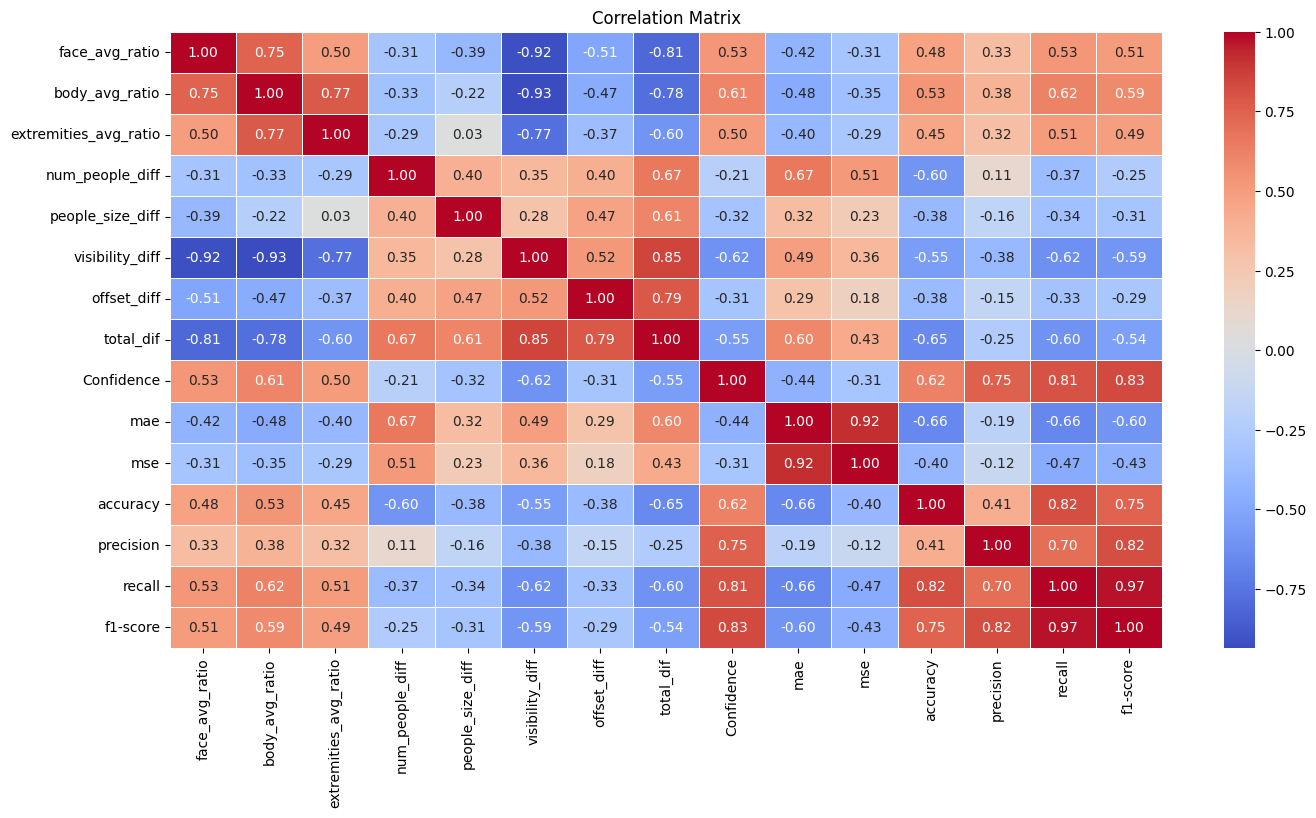

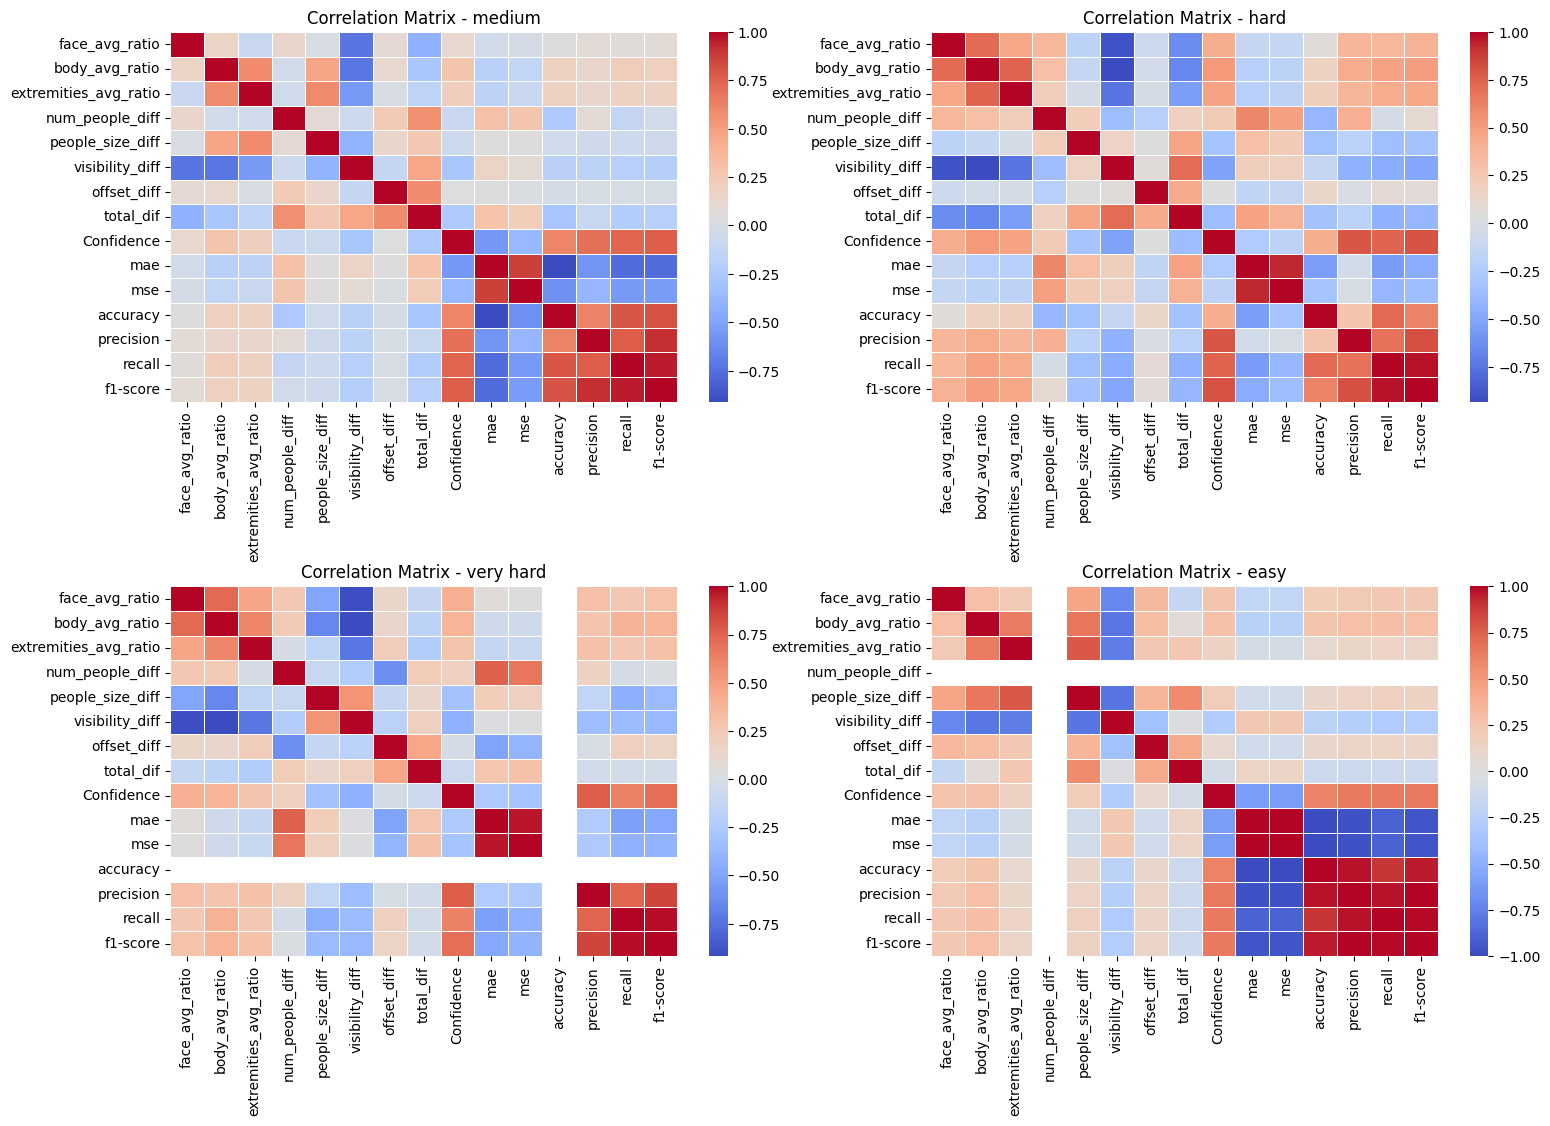

--------------------
      Top25      
--------------------


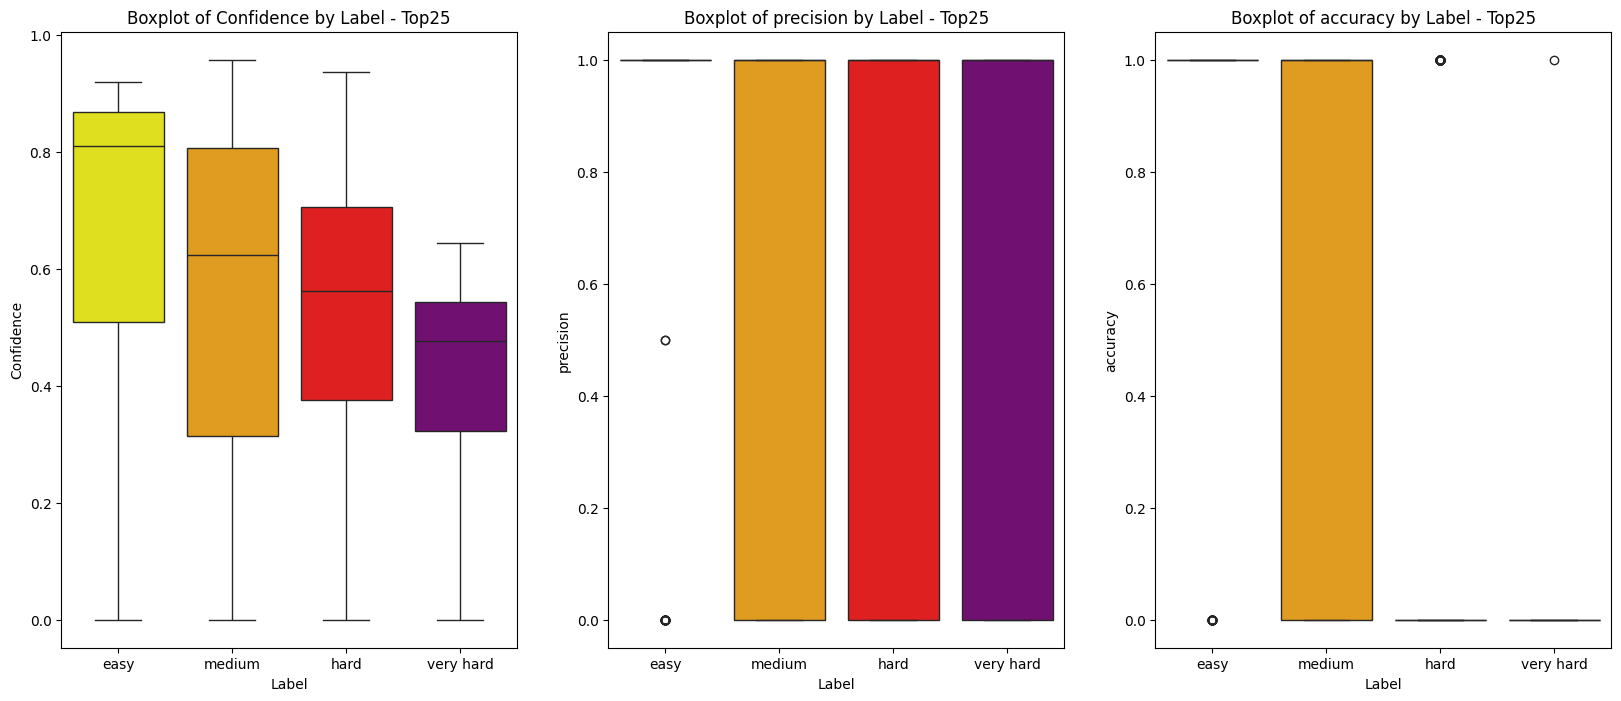

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.243902   0.243902  0.756098   0.762195  0.493865
hard       1.905013   8.079156  0.242744   0.697142  2.842386
medium     0.587276   0.890701  0.518760   0.653290  0.943770
very hard  4.823529  34.470588  0.058824   0.647059  5.871166


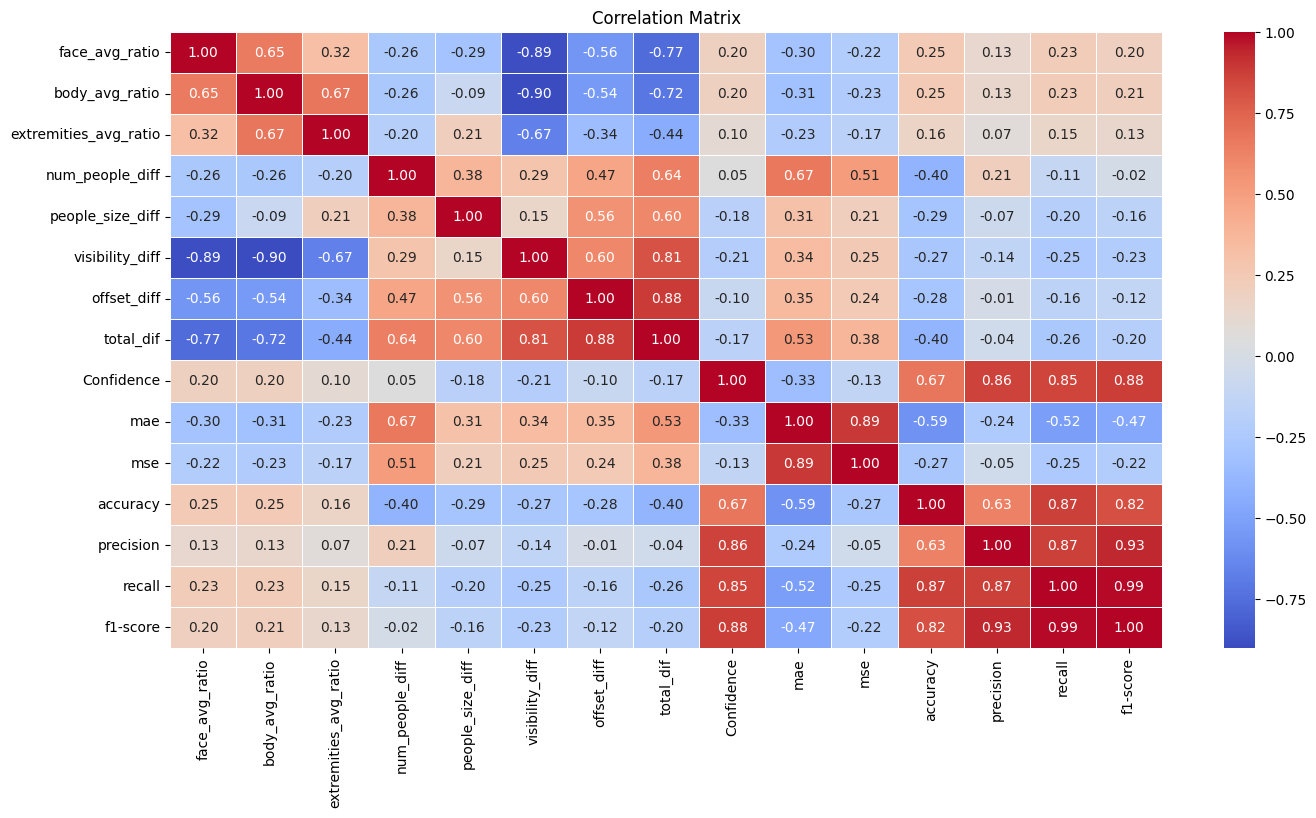

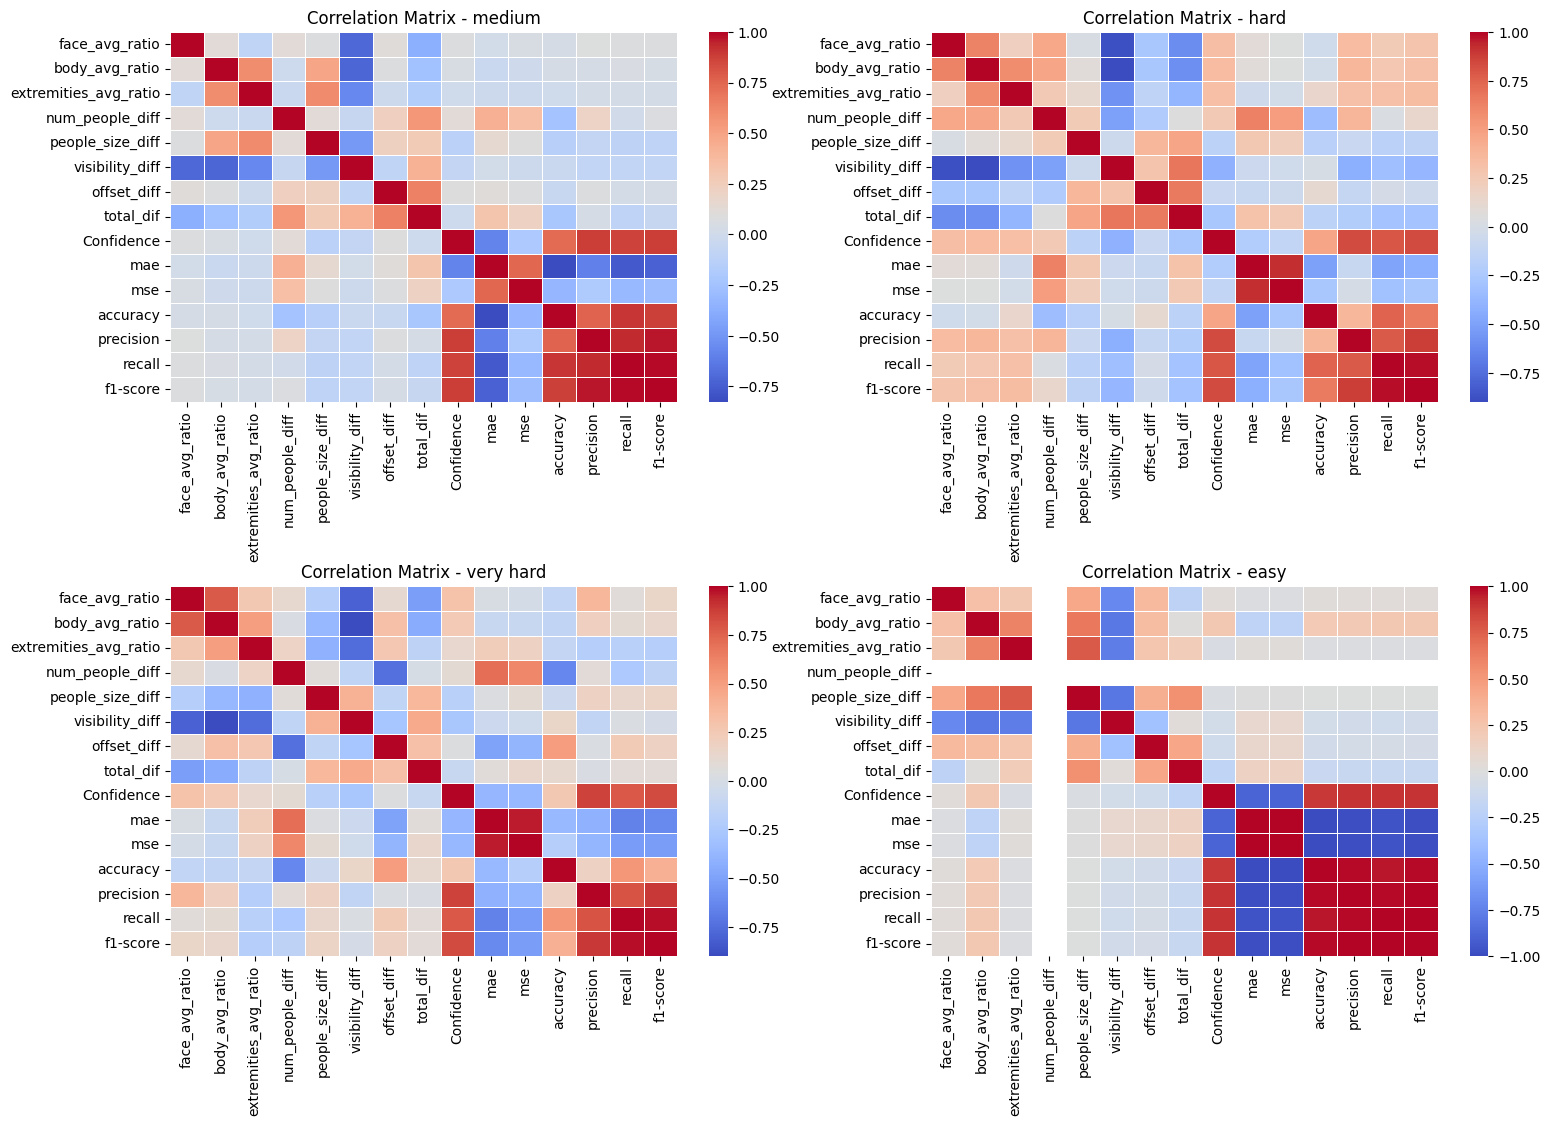

--------------------
      Top50      
--------------------


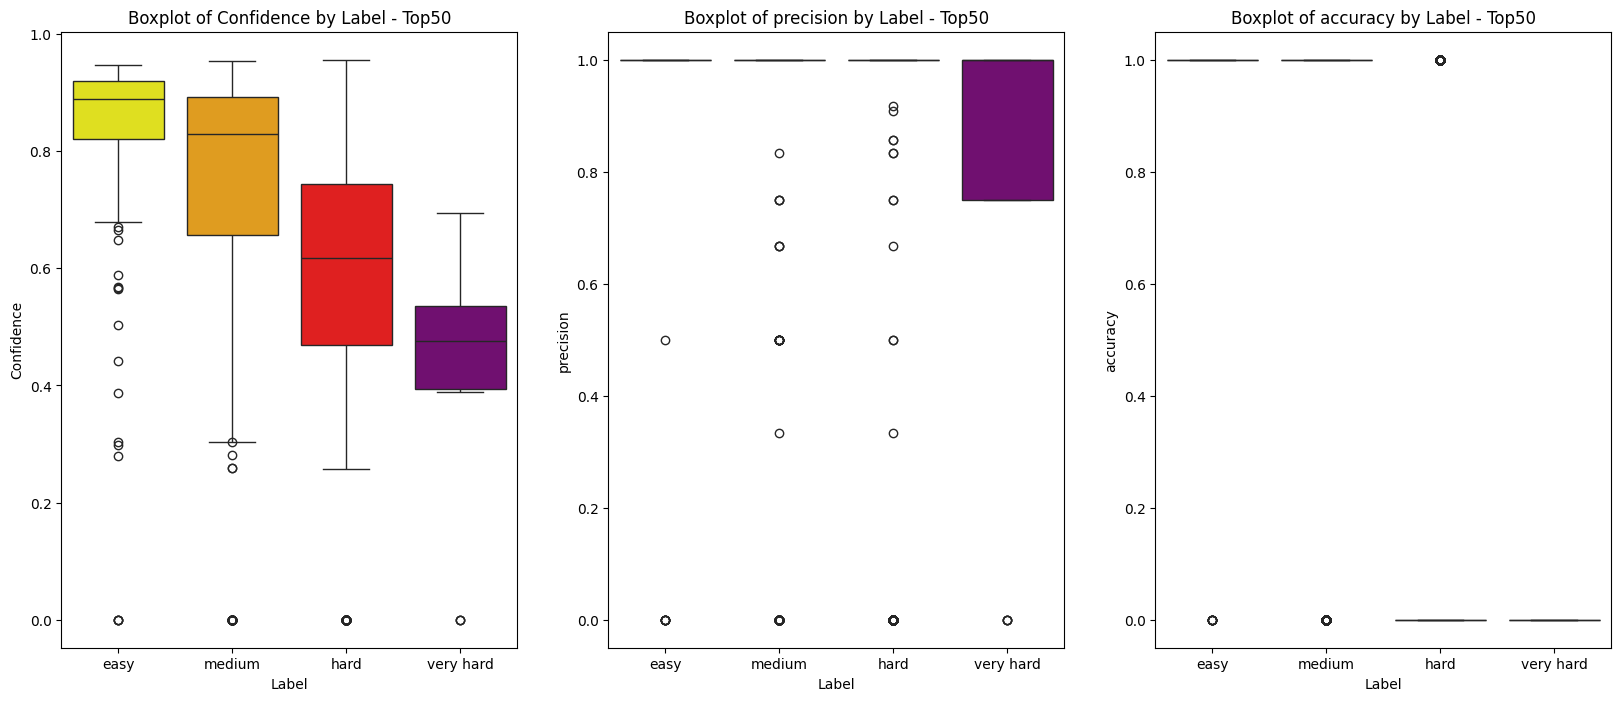

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.057325   0.057325  0.942675   0.945860  0.239426
hard       2.089572   9.311497  0.231283   0.787041  3.051475
medium     0.266344   0.401937  0.776029   0.882466  0.633985
very hard  5.500000  38.625000  0.000000   0.750000  6.214901


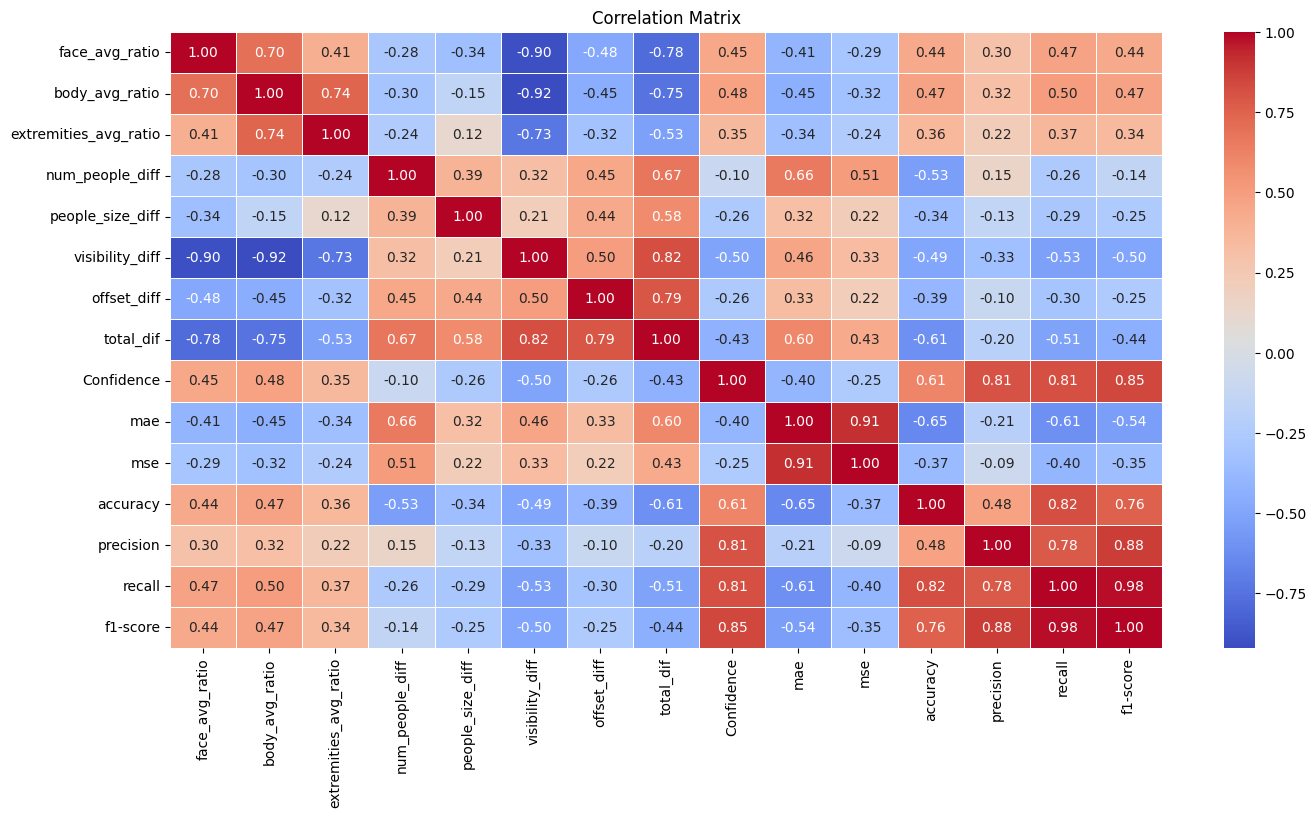

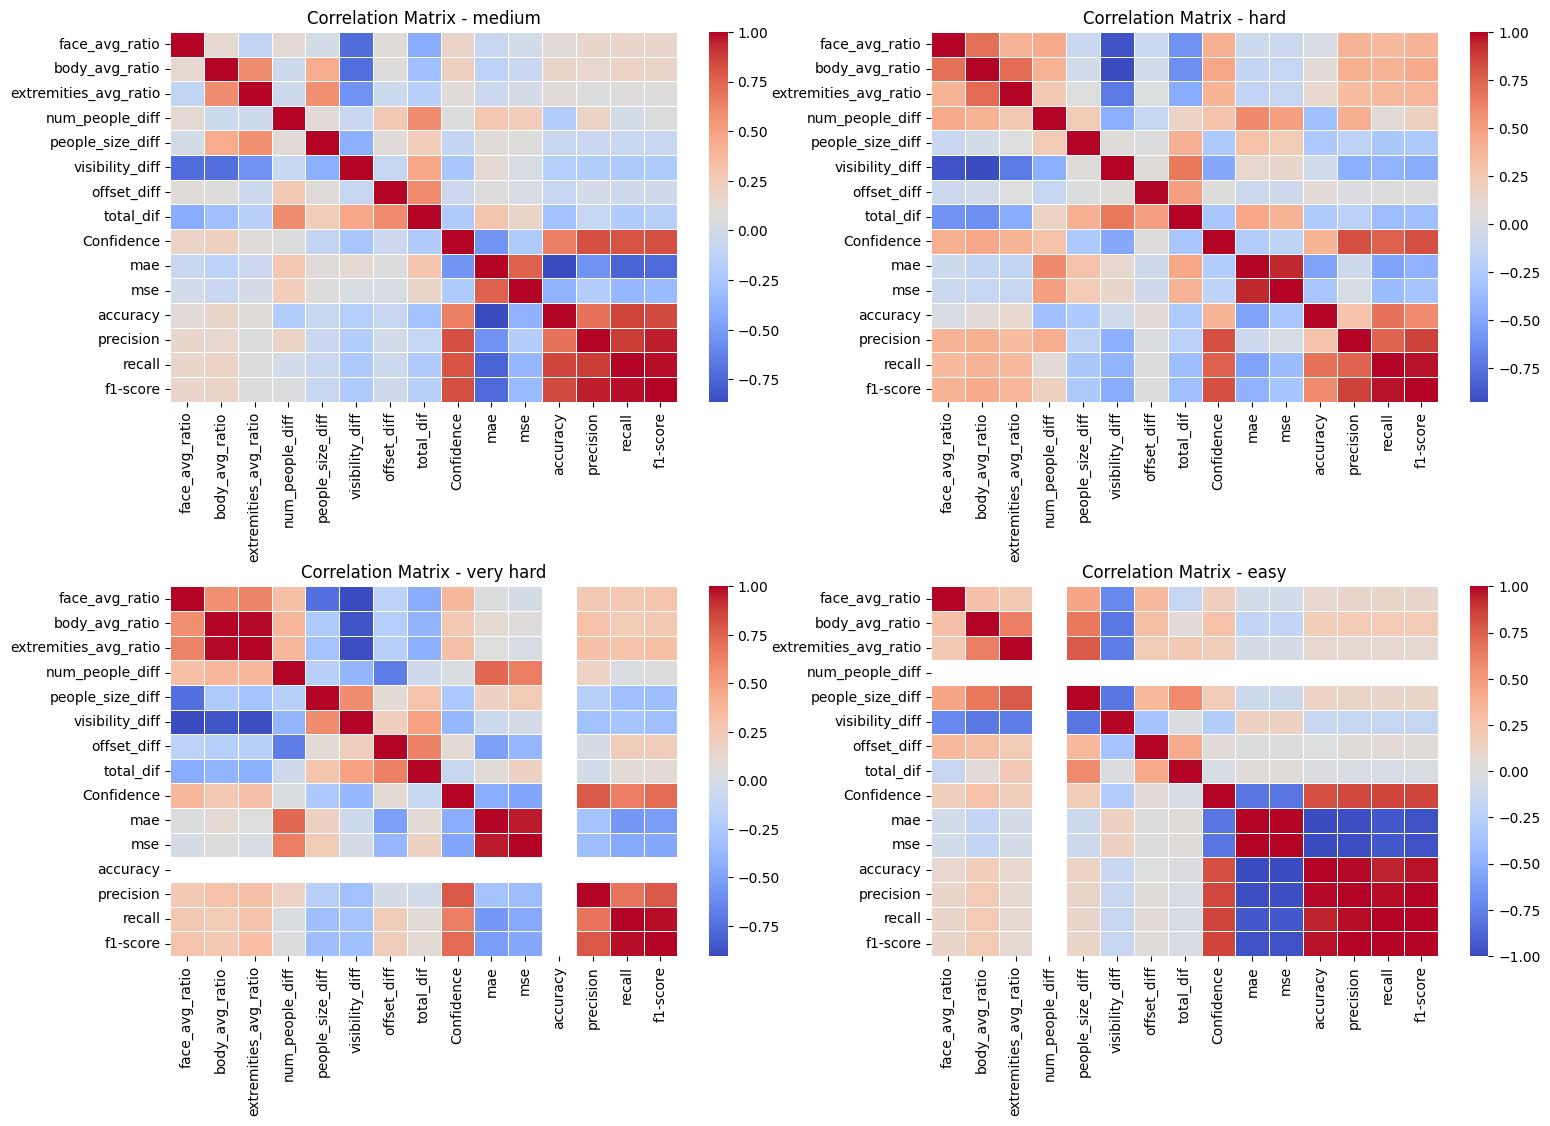

--------------------
      Top75      
--------------------


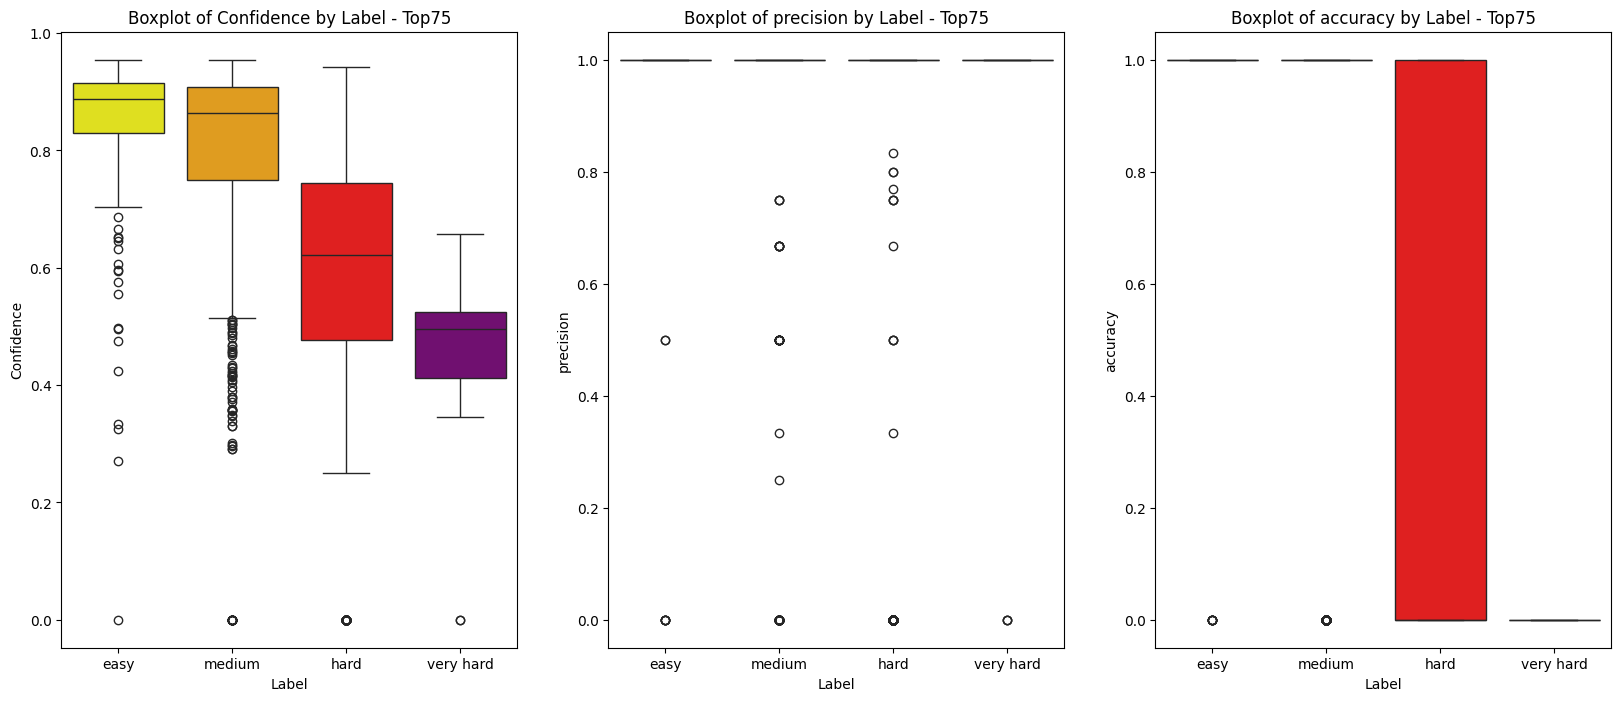

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.052632   0.052632  0.947368   0.953947  0.229416
hard       2.105858  10.017472  0.263104   0.824206  3.165039
medium     0.192831   0.264524  0.835600   0.920066  0.514319
very hard  5.380952  39.571429  0.000000   0.857143  6.290583


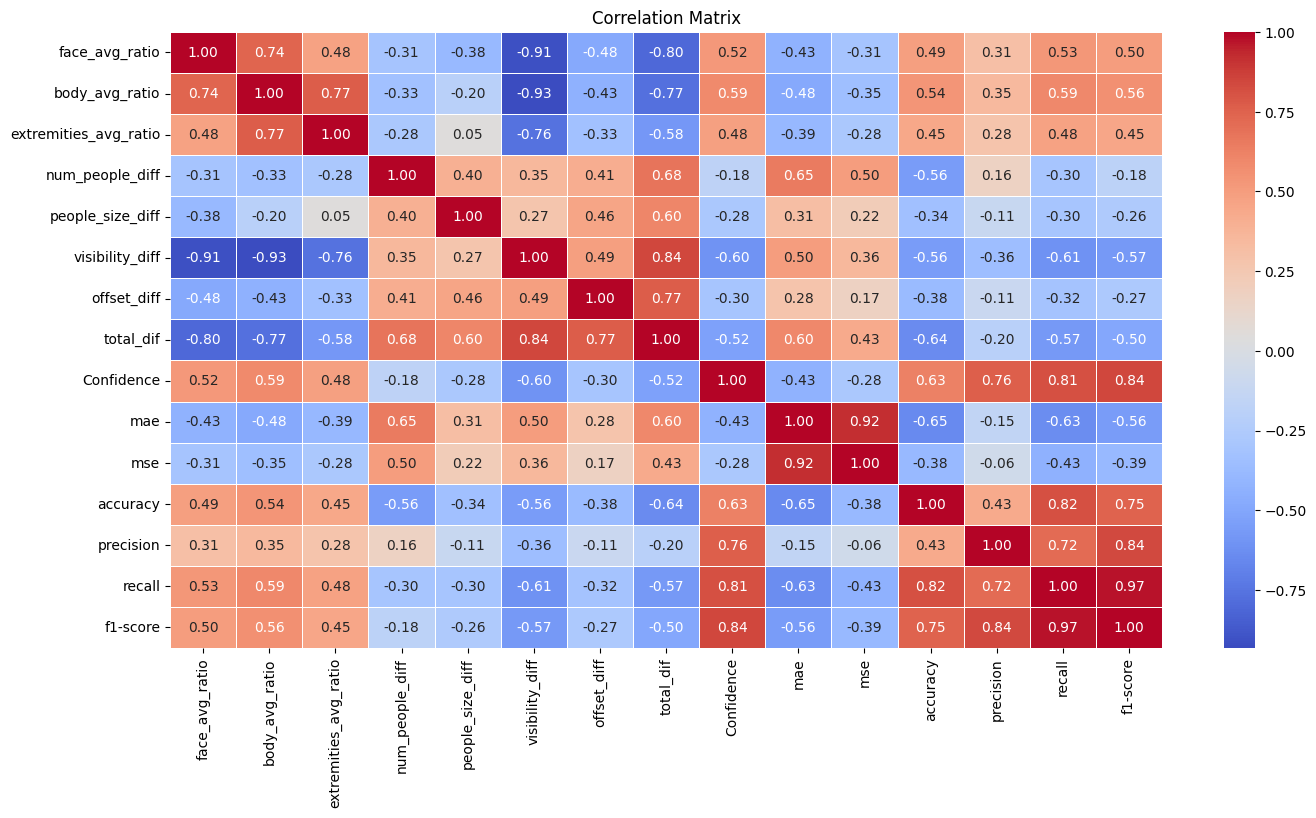

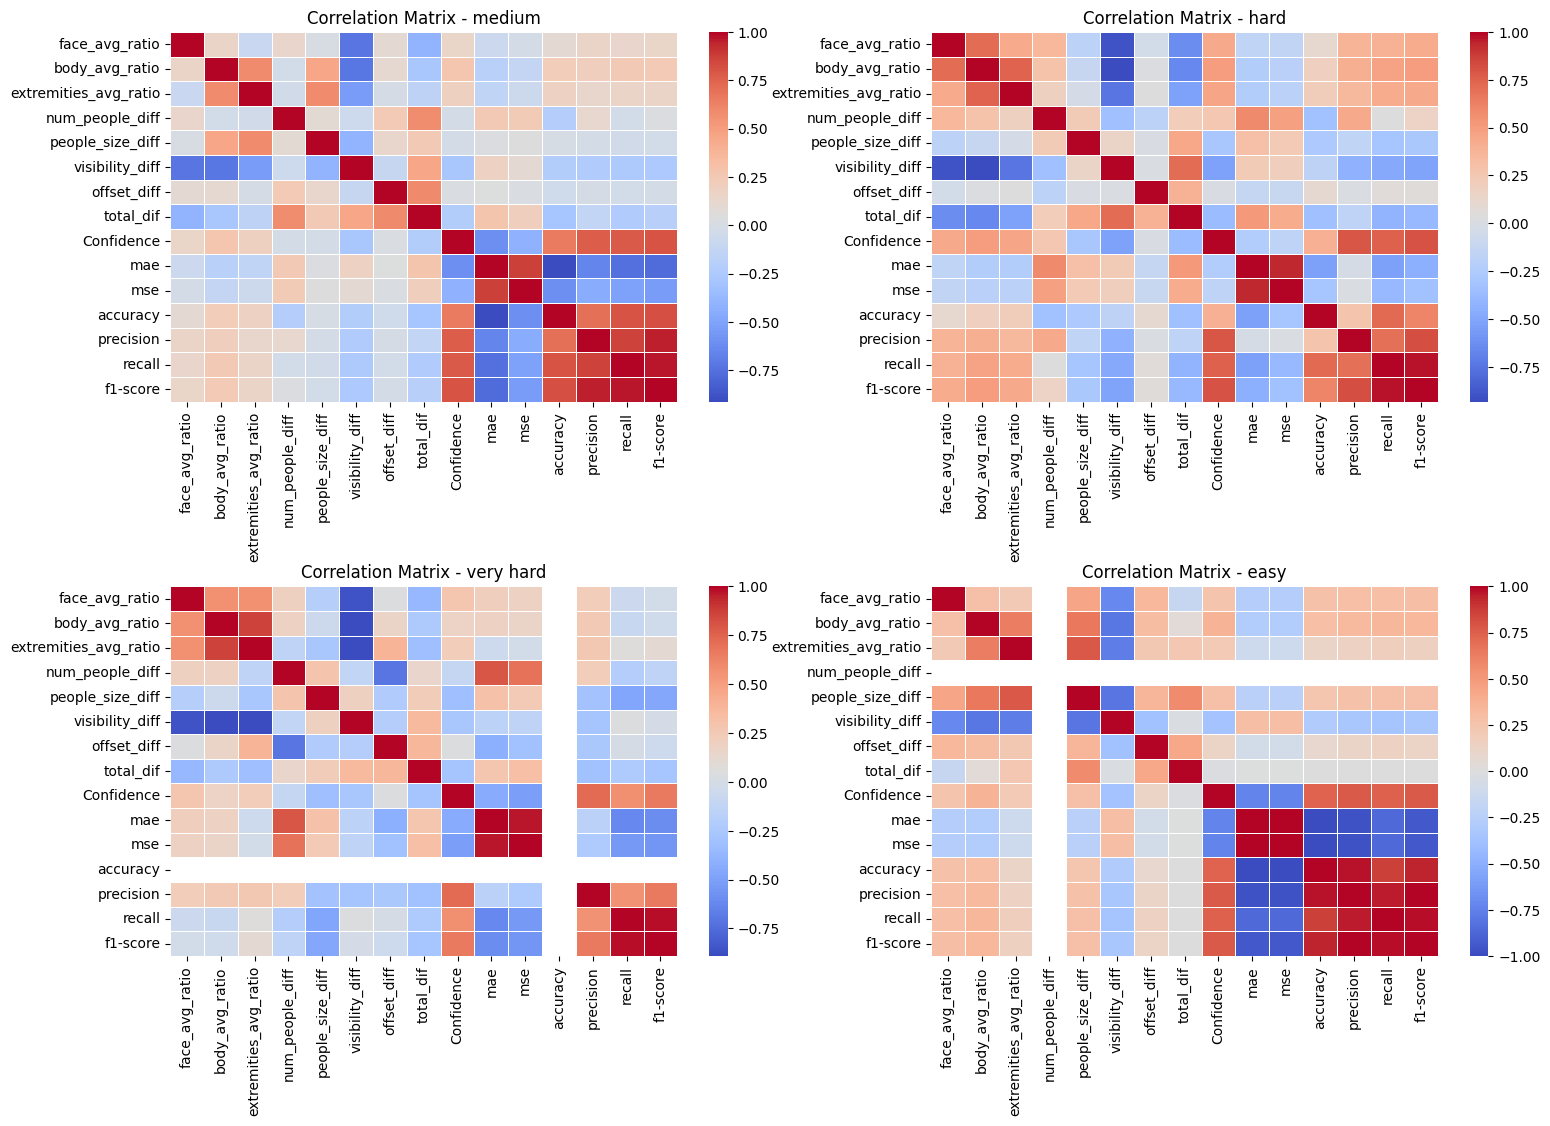

--------------------
      Side25      
--------------------


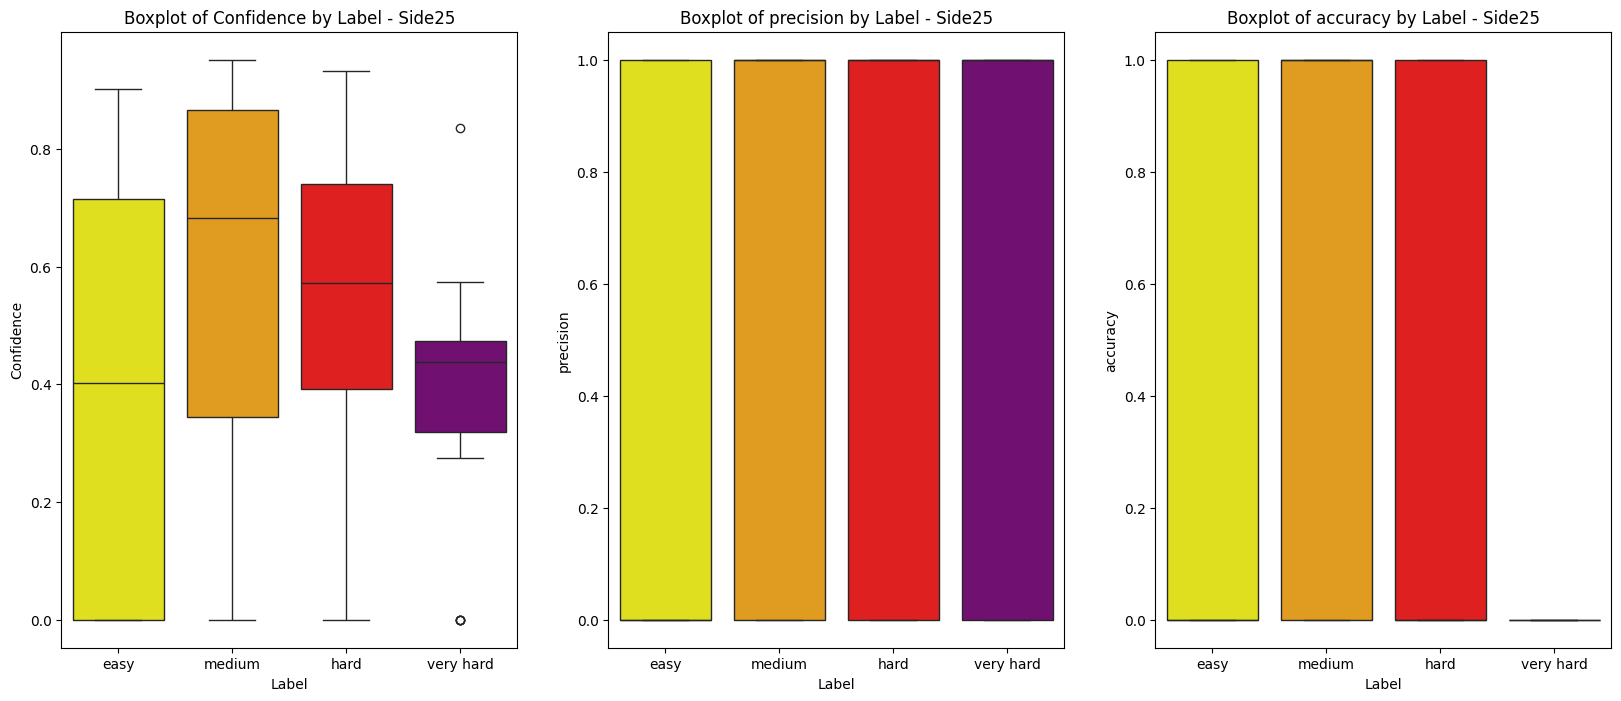

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.576271   0.576271  0.423729   0.423729  0.759125
hard       1.146568   2.730983  0.324675   0.701299  1.652569
medium     0.460377   0.535849  0.575472   0.676415  0.732017
very hard  3.130435  11.739130  0.000000   0.565217  3.426241


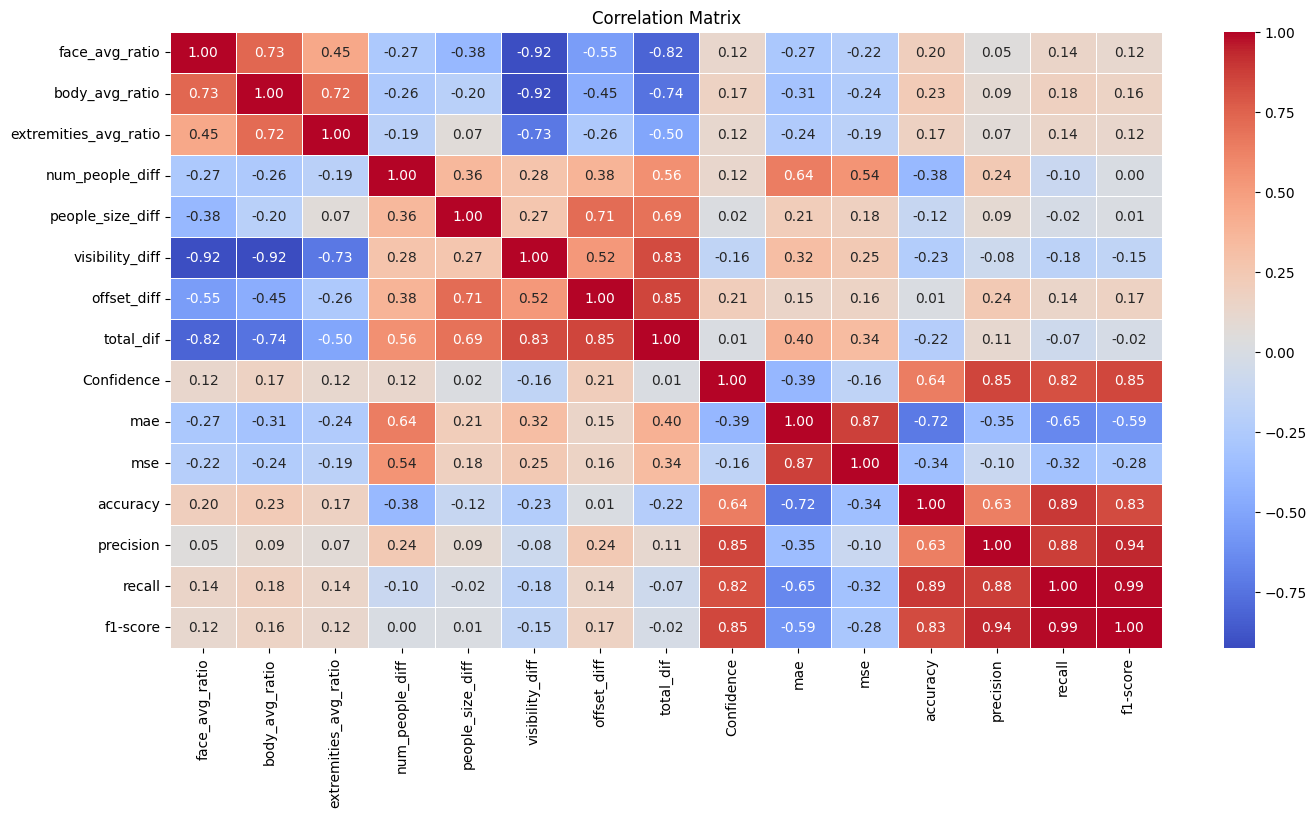

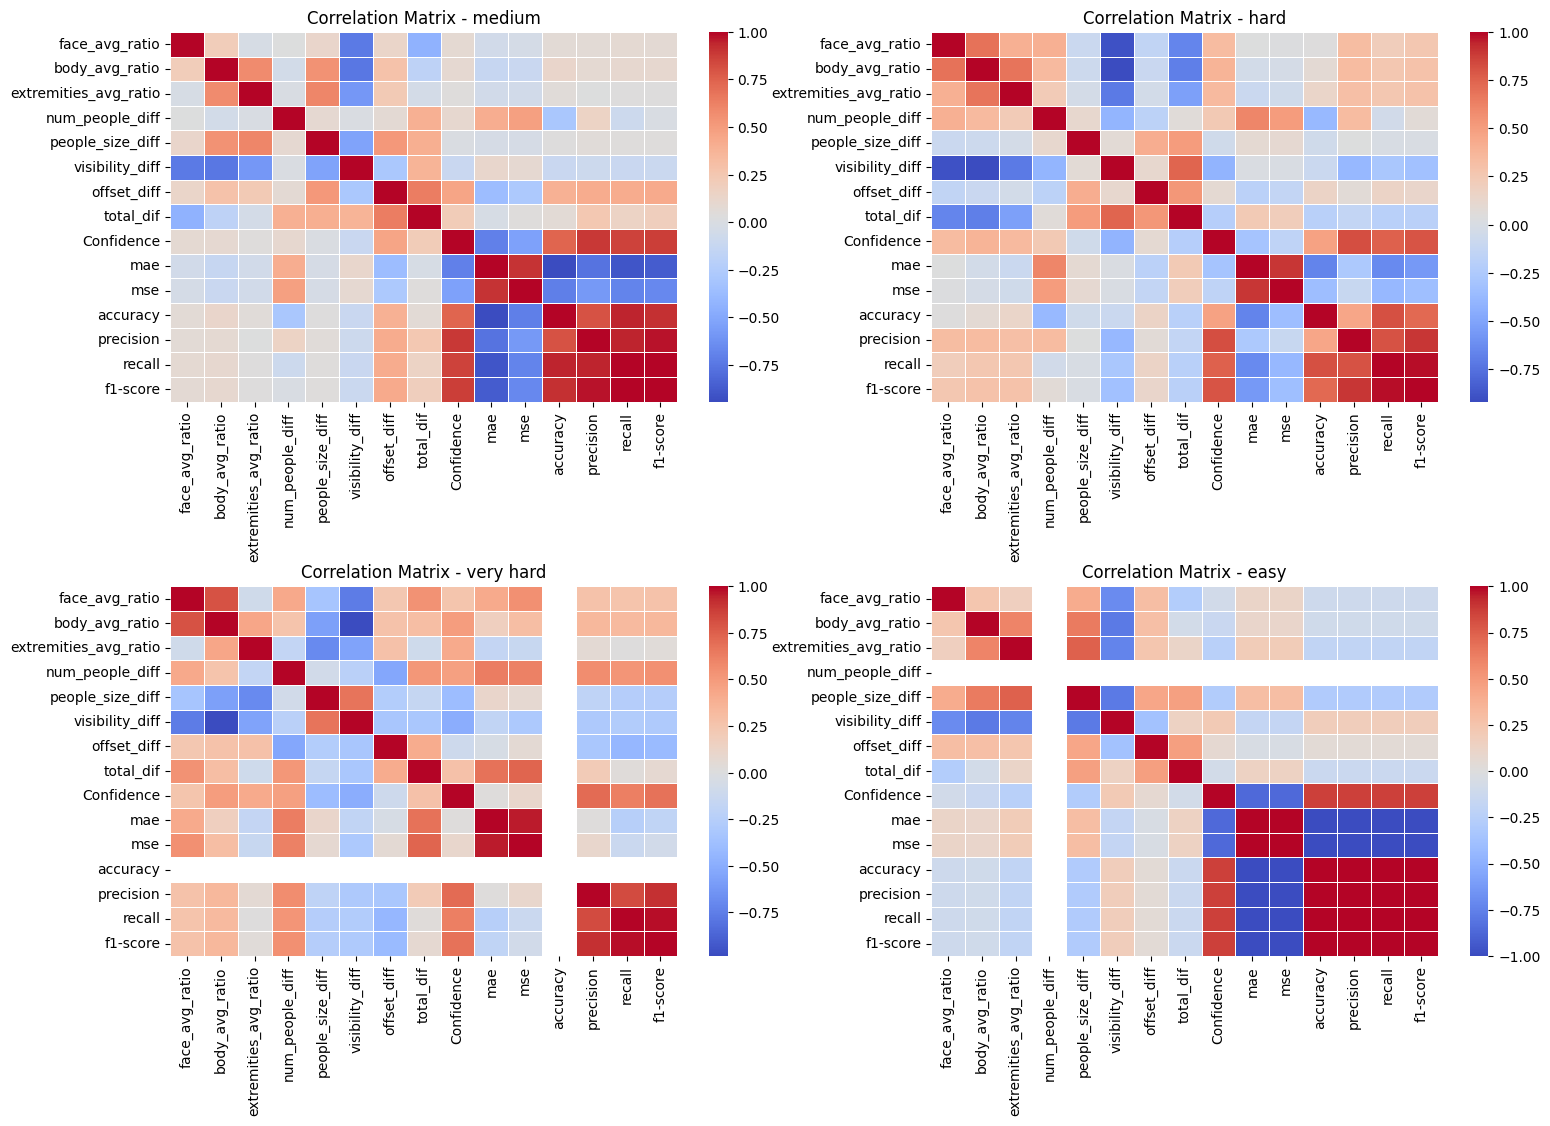

--------------------
      Side50      
--------------------


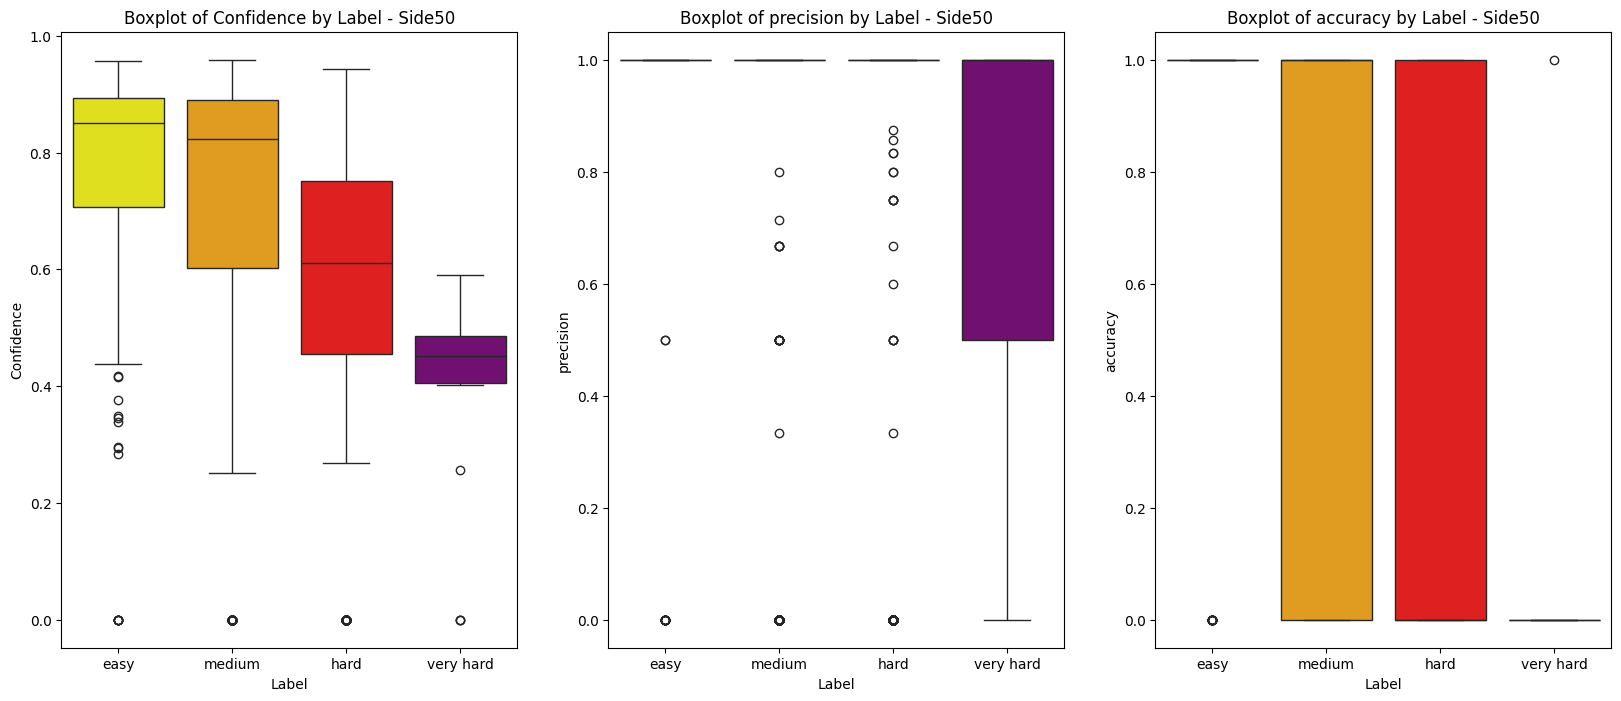

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.139394   0.139394  0.860606   0.866667  0.373355
hard       1.575246   5.206751  0.268636   0.775807  2.281831
medium     0.404789   0.532497  0.645382   0.831829  0.729724
very hard  3.684211  16.526316  0.052632   0.736842  4.065257


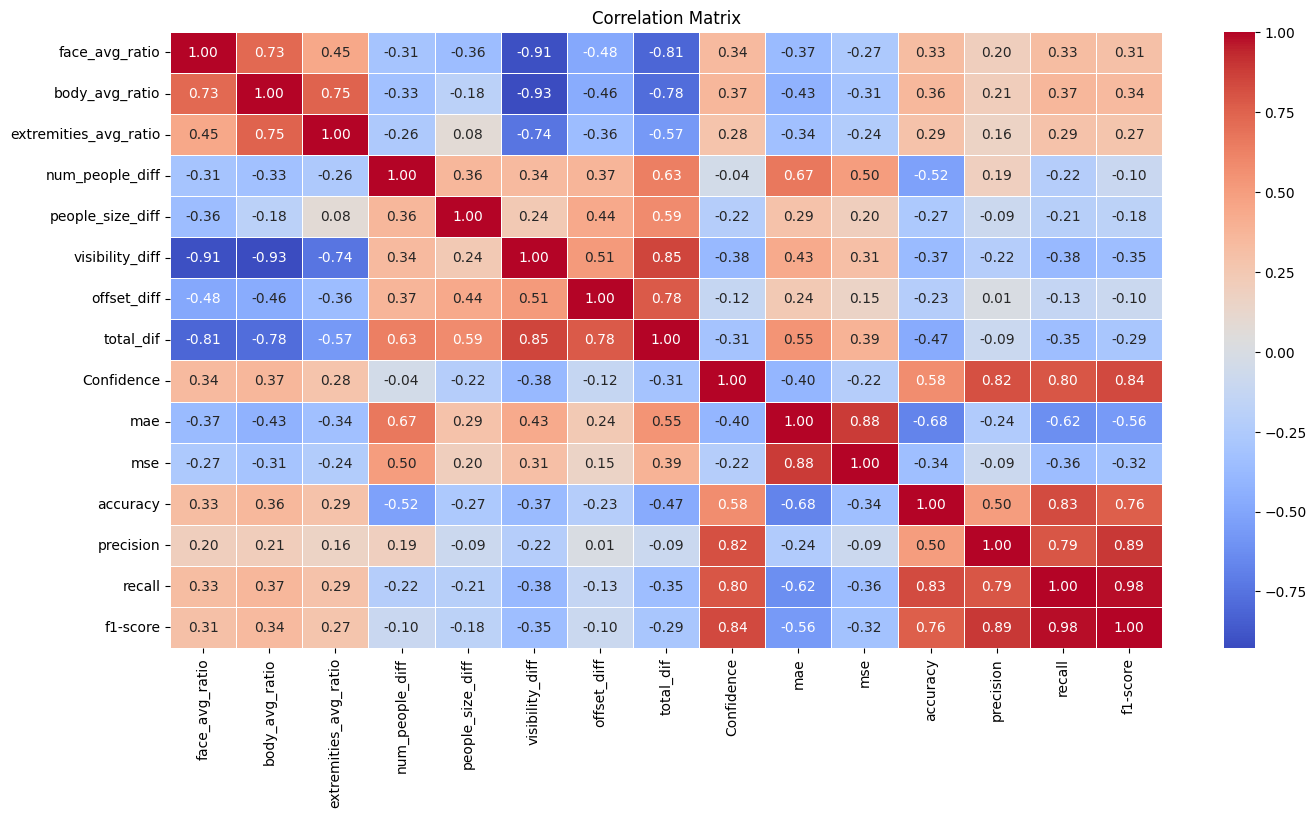

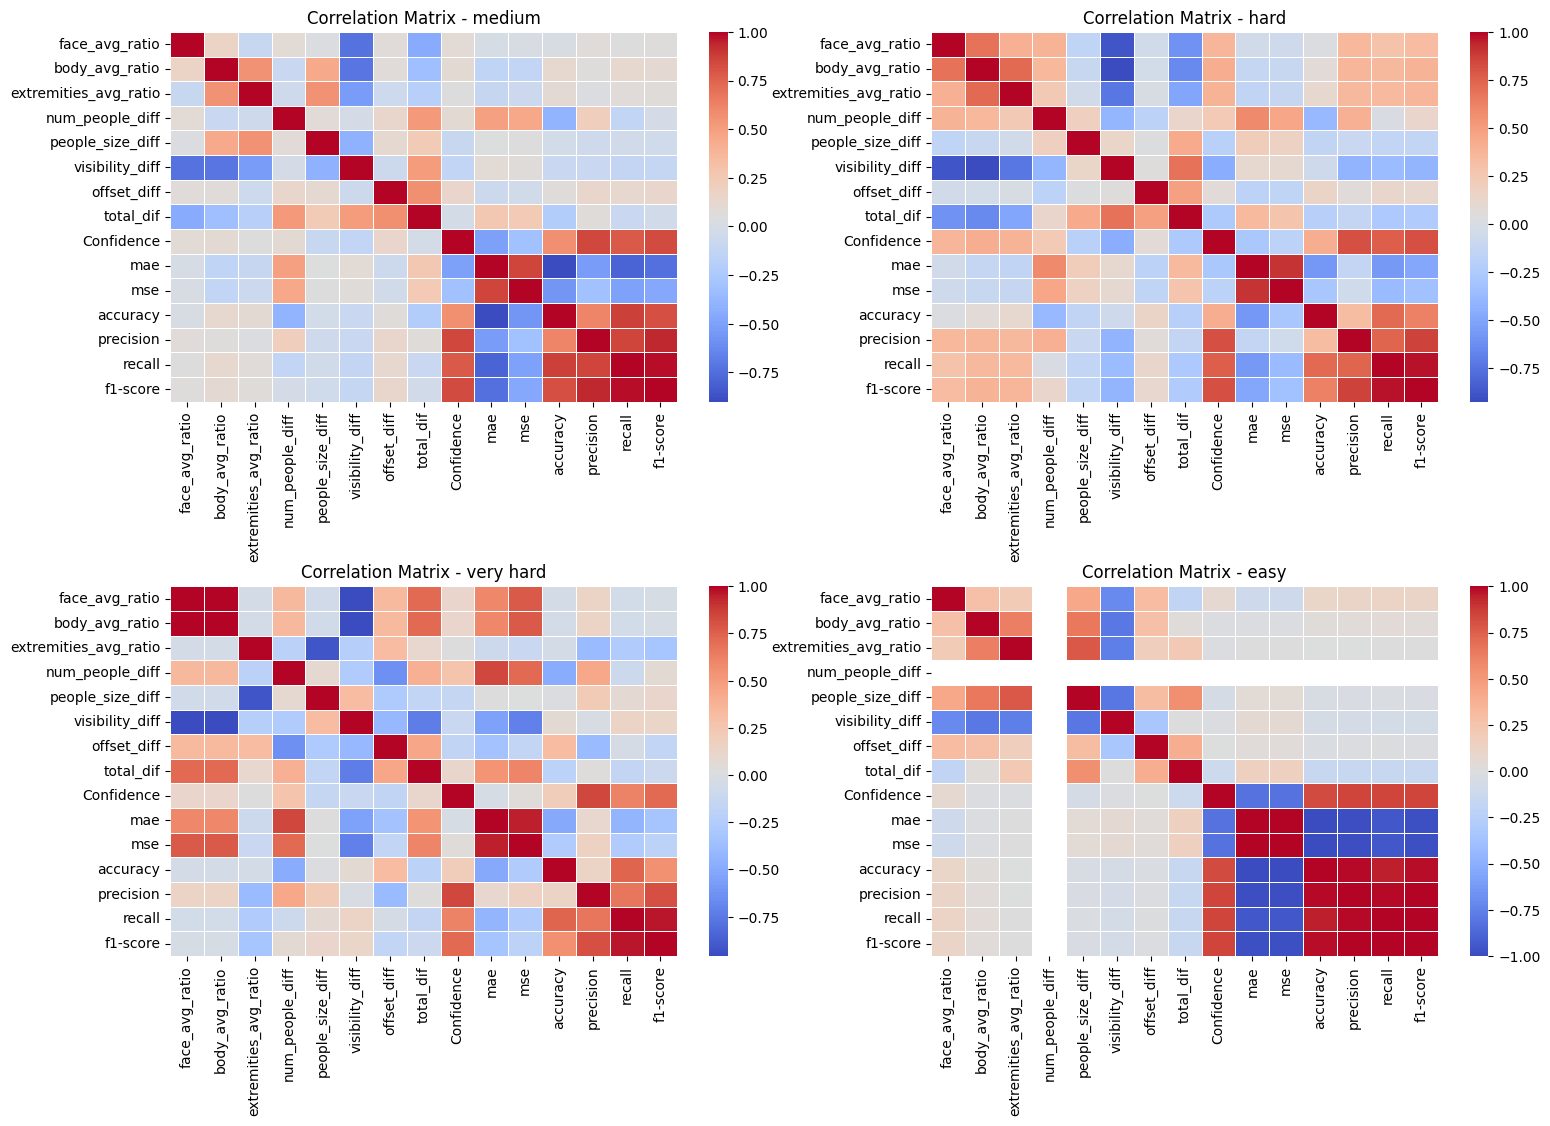

--------------------
      Side75      
--------------------


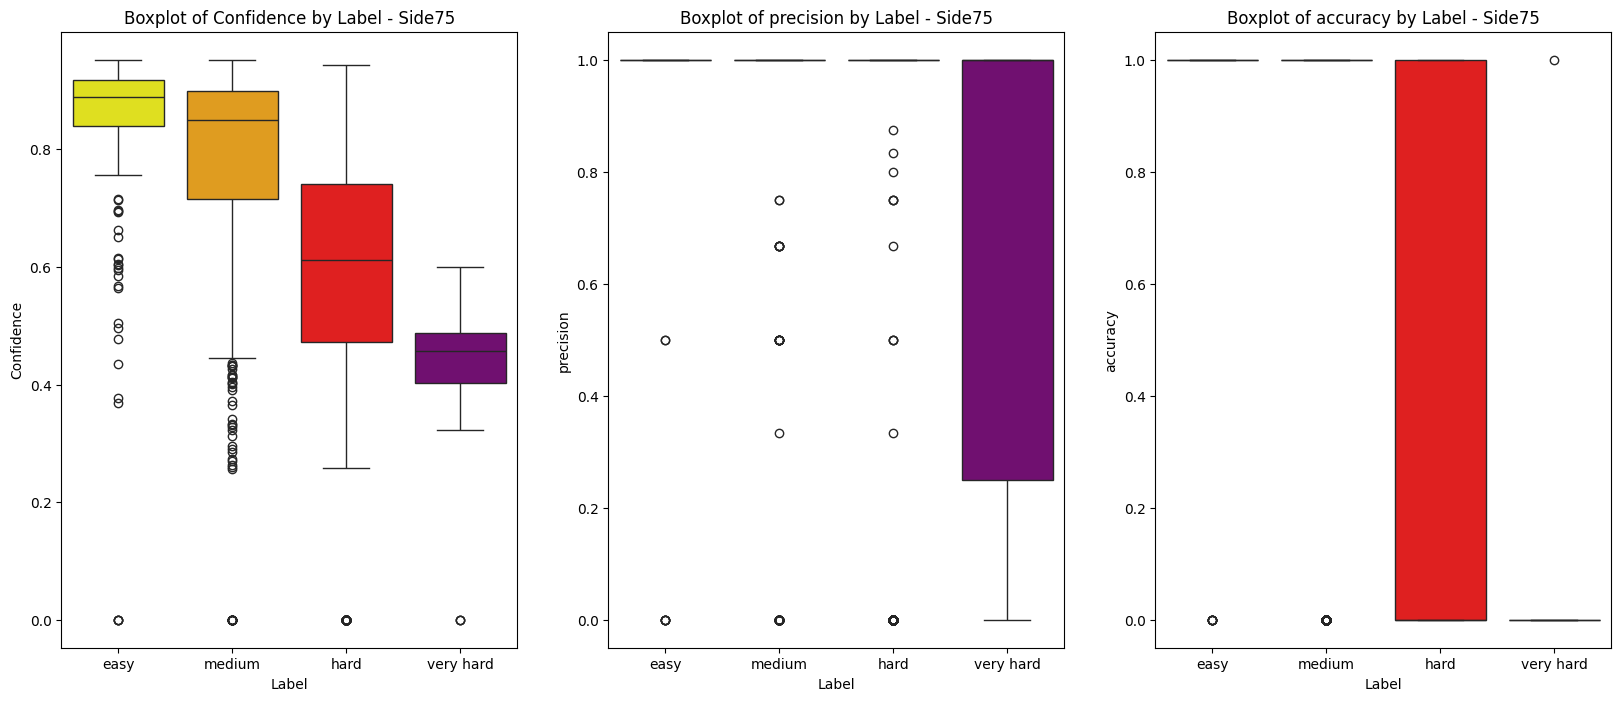

                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.051948   0.051948  0.948052   0.954545  0.227921
hard       1.861364   7.500000  0.255682   0.791203  2.738613
medium     0.236872   0.315084  0.798883   0.931099  0.561323
very hard  4.818182  29.181818  0.045455   0.727273  5.402020


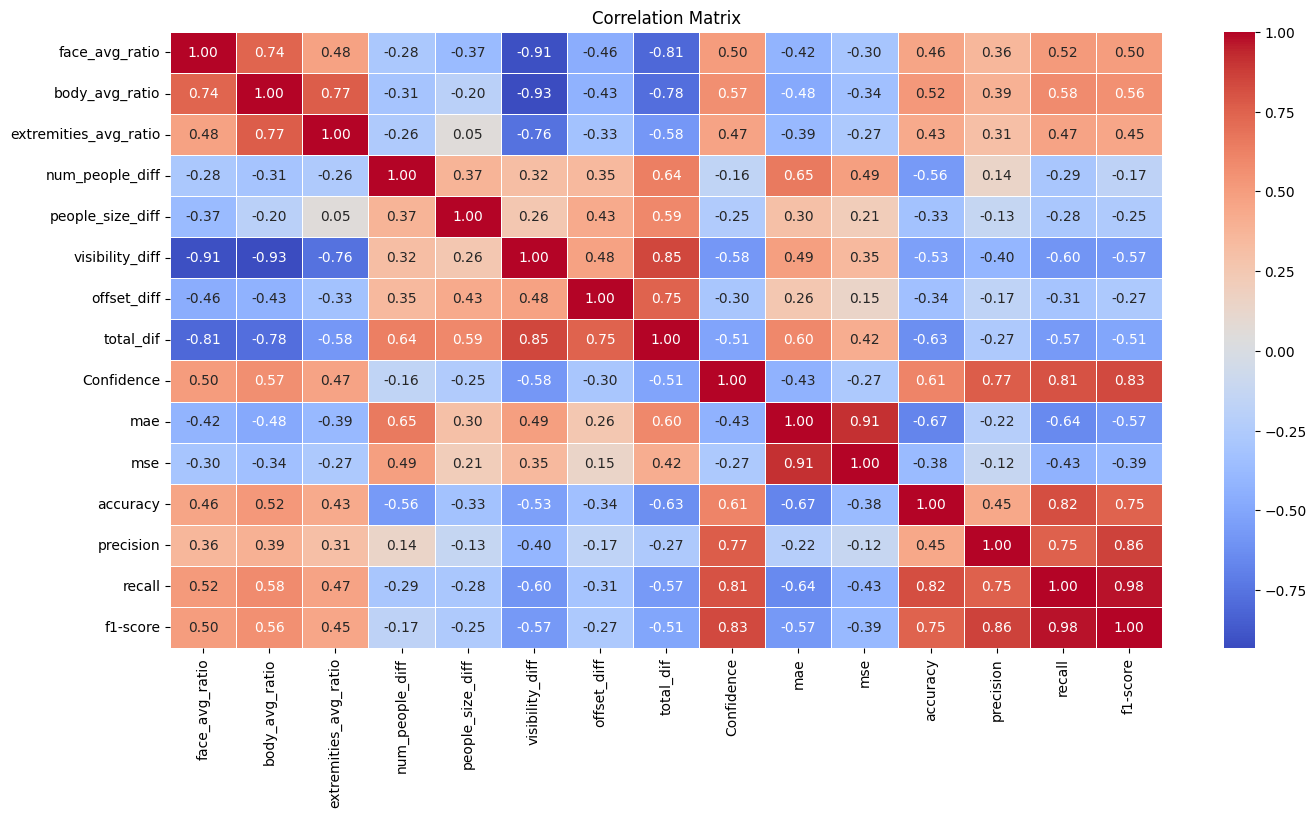

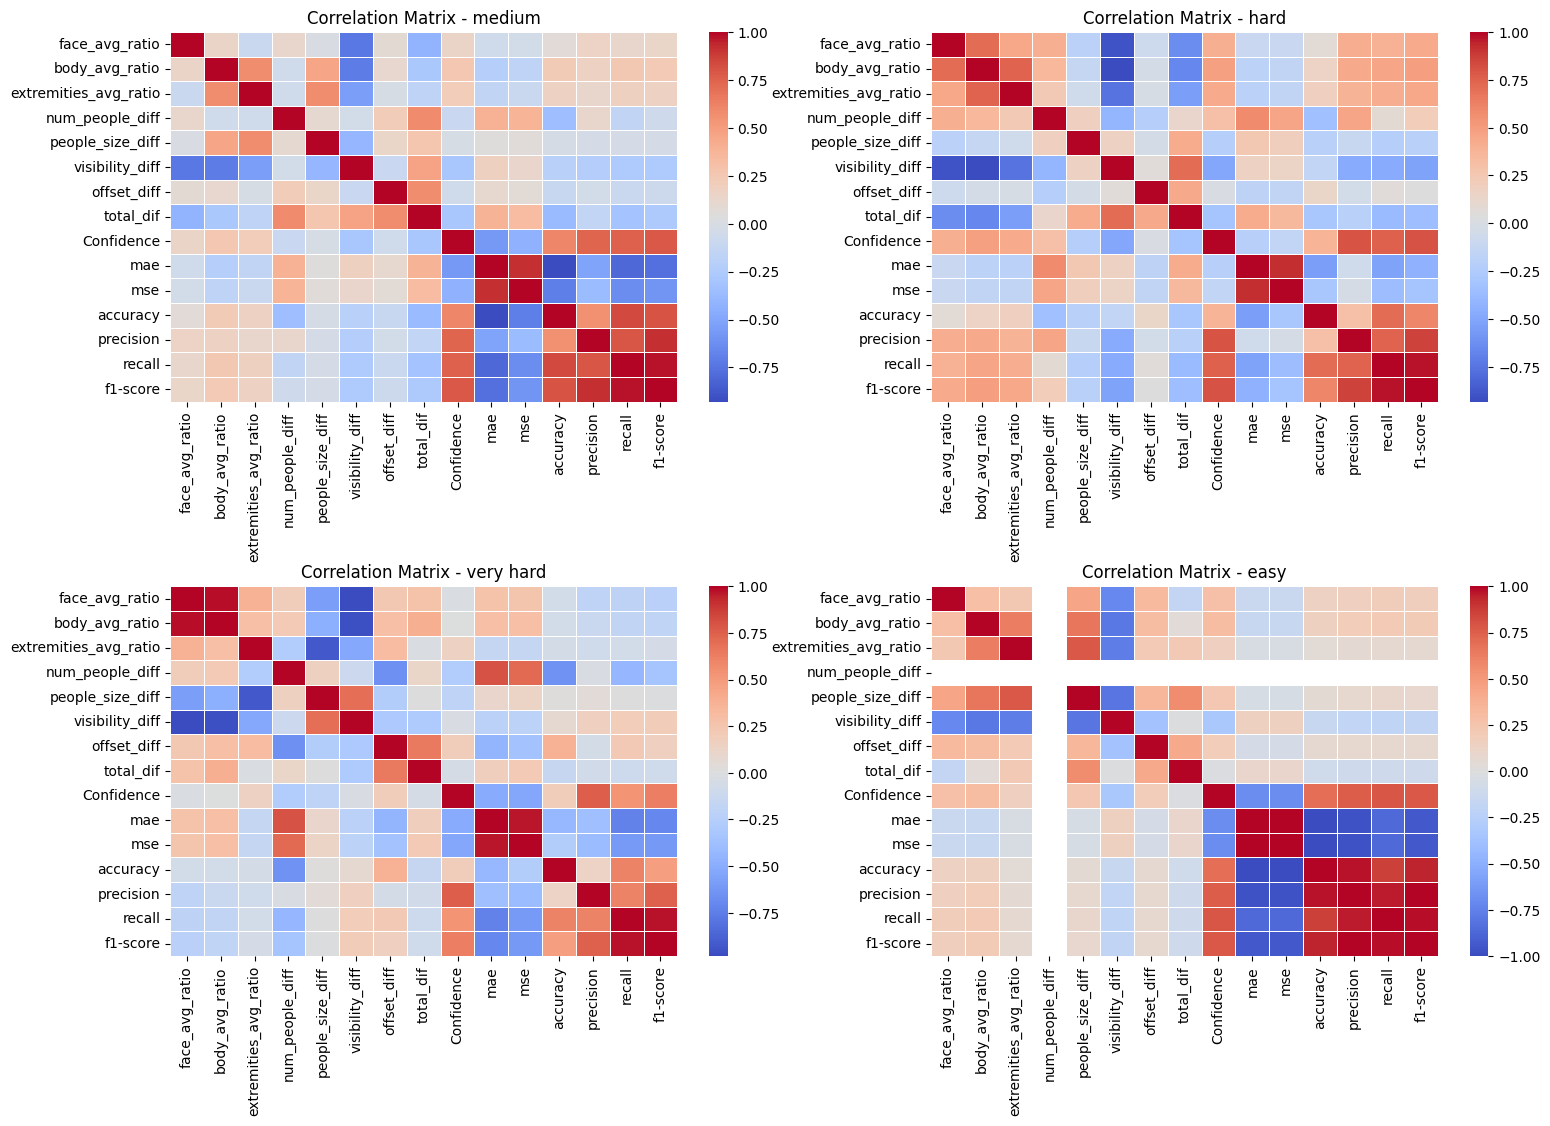

In [424]:
df_list = []
for name in df_names:
    pred_df = pd.read_csv(f'./data/yolo_prediction/{name}.csv')
    anns_df = pd.read_csv(f'./data/coco_diff/{name}.csv')
    anns_df = apply_total_dif_labeling(anns_df, 'total_dif')
    detect_on_threshold(pred_df, 0.5)
    group_pred_df = group_predictions(pred_df)
    df = pd.merge(anns_df, group_pred_df, how='inner', left_on='Img', right_on='Img_ID')
    df.set_index('Img', inplace=True)
    adding_precision_feature(df)
    adding_metrics_features(df)
    df_list.append(df)
    
    print('-'*20)
    print(' '*5, name, ' '*5)
    print('-'*20)


    plt.figure(figsize=(20,8))
    plt.subplot(1, 3, 1)
    plot_grouped_boxplot(df, 'Confidence', name=name, subplot=True)
    plt.subplot(1, 3, 2)
    plot_grouped_boxplot(df, 'precision', name=name, subplot=True)
    plt.subplot(1, 3, 3)
    plot_grouped_boxplot(df, 'accuracy', name=name, subplot=True)
    plt.show()
    
    print(group_df_and_agg_metrics(df))
    plt.figure(figsize=(16,8))
    correlation_matrix = df.drop(['label', 'num_people', 'detected', 'false_pos', 'false_neg', 'true_pos', 'offset', 'Format'], axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()
    
    correlation_matrices = {}


    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()

    for index, label in enumerate(df['label'].unique()):
        df_label = df[df['label'] == label]
        correlation_matrix = df_label.drop(['label', 'num_people', 'detected', 'false_pos', 'false_neg', 'true_pos', 'offset', 'Format'], axis=1).corr()        
        
        plt.subplot(2, 2, index+1)
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title(f'Correlation Matrix - {label}')
        
    plt.subplots_adjust(hspace=0.5, wspace=0.2) 
    plt.show()



### PCA

In [425]:
df_pca = df_pca.drop(['detected', 'num_people'], axis=1)

In [426]:
df_pca

offset  face_avg_ratio  body_avg_ratio  extremities_avg_ratio  \
Img                                                                       
326     0.152845        0.800000        1.000000               0.125000   
1149    0.457257        0.566667        0.510417               0.416667   
1200    0.634782        0.000000        0.000000               0.000000   
1319    0.509654        0.600000        0.500000               0.812500   
1900    0.254233        0.000000        0.000000               0.000000   
...          ...             ...             ...                    ...   
579891  0.345929        0.800000        1.000000               1.000000   
580781  0.205454        0.600000        0.750000               0.250000   
581183  0.517451        0.150000        0.416667               0.354167   
581278  0.088761        1.000000        1.000000               0.500000   
581557  0.039613        0.400000        1.000000               0.437500   

        num_people_diff  people_size_diff  visibility_diff  offset_diff  \
Img                                                                       
326            0.500000          0.777912         0.275000     0.152845   
1149           0.923077          0.968225         0.480208     0.457257   
1200           0.750000          0.999022         1.000000     0.634782   
1319           0.500000          0.946072         0.387500     0.509654   
1900           0.500000          0.994862         1.000000     0.254233   
...                 ...               ...              ...          ...   
579891         0.500000          0.936058         0.100000     0.345929   
580781         0.500000          0.531672         0.425000     0.205454   
581183         0.923077          0.993702         0.729167     0.517451   
581278         0.500000          0.663991         0.100000     0.088761   
581557         0.500000          0.830860         0.412500     0.039613   

        total_dif   label  Confidence Format  
Img                                           
326      0.426439  medium    0.866764    rgb  
1149     0.707192    hard    0.607025    rgb  
1200     0.845951    hard    0.739418    rgb  
1319     0.585807  medium    0.431452    rgb  
1900     0.687274    hard    0.000000    b&w  
...           ...     ...         ...    ...  
579891   0.470497  medium    0.909920    rgb  
580781   0.415531  medium    0.841013    rgb  
581183   0.790849    hard    0.605279    rgb  
581278   0.338188    easy    0.803501    rgb  
581557   0.445743  medium    0.801042    rgb  

[2001 rows x 12 columns]

In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib import cm

def draw_PCA(df):
    X = df.drop(['Confidence', 'label', 'Format'], axis=1)
    confidence = df['Confidence'] 

    label_encoder = OneHotEncoder(drop='first', dtype=int)
    labels_encoded = label_encoder.fit_transform(df[['label']]).toarray()

    format_encoder = OneHotEncoder(drop='first', dtype=int)
    format_encoded = format_encoder.fit_transform(df[['Format']]).toarray()

    X_encoded = np.hstack([X.values, labels_encoded, format_encoded]) 

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    pca = PCA(n_components=2) 
    X_pca = pca.fit_transform(X_scaled)

    label_colors = {'easy': 'g', 'medium': 'b', 'hard': 'r', 'very hard': 'y'}

    plt.figure(figsize=(8, 6))
    plt.hexbin(X_pca[:, 0], X_pca[:, 1], C=confidence, gridsize=30, cmap='viridis', reduce_C_function=np.mean)
    plt.colorbar(label='Confidence')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA con hexbin, colorato in base a Confidence')

    plt.figure(figsize=(8, 6))
    loading_vectors = pca.components_

    arrow_scale = 1.5 

    all_columns = list(X.columns) + list(label_encoder.get_feature_names_out(['label'])) + list(format_encoder.get_feature_names_out(['Format']))

    for i, (col_name, vec) in enumerate(zip(all_columns, loading_vectors.T)):
        x_end = vec[0] * arrow_scale
        y_end = vec[1] * arrow_scale
        
        plt.arrow(0, 0, x_end, y_end, color='black', alpha=0.7, head_width=0.03, head_length=0.05, linewidth=1.5)
        
        plt.text(x_end * 1.2, y_end * 1.2, col_name, color='black', ha='center', va='center')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Loading Vectors')

    # Mostra i grafici
    plt.show()


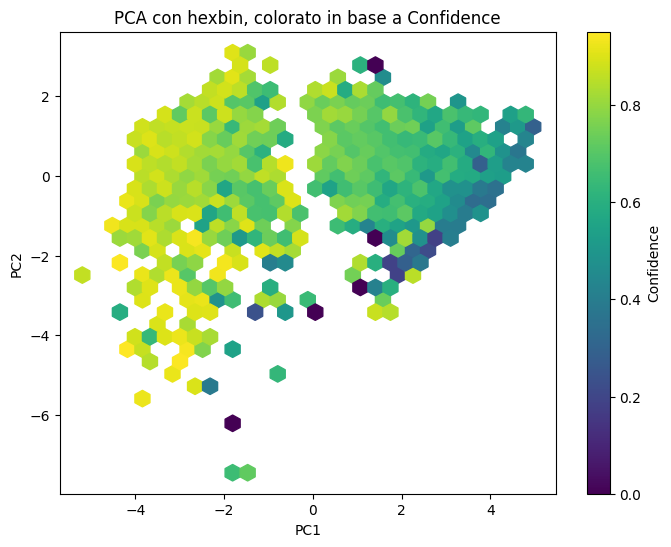

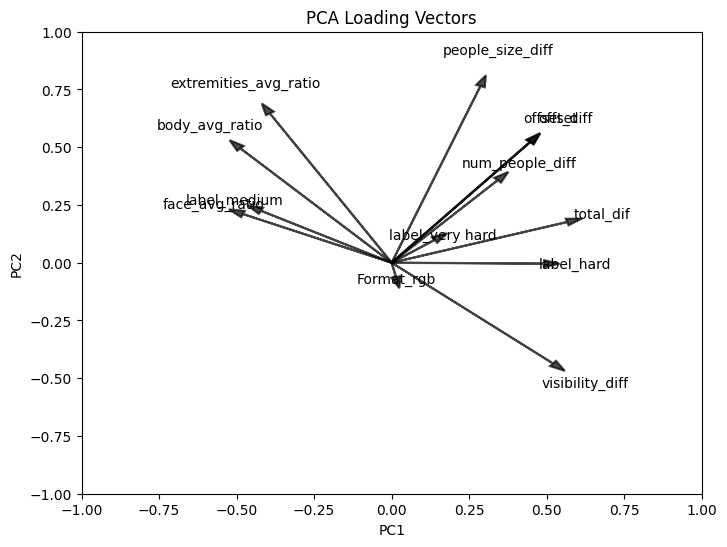

In [428]:
draw_PCA(df_pca)

## Channels analysis

In [429]:
df_list[0]

num_people    offset  face_avg_ratio  body_avg_ratio  \
Img                                                            
326              1  0.152845        0.800000        1.000000   
1149            12  0.457257        0.566667        0.510417   
1200             3  0.634782        0.000000        0.000000   
1319             1  0.509654        0.600000        0.500000   
1900             1  0.254233        0.000000        0.000000   
...            ...       ...             ...             ...   
579891           1  0.345929        0.800000        1.000000   
580781           1  0.205454        0.600000        0.750000   
581183          12  0.517451        0.150000        0.416667   
581278           1  0.088761        1.000000        1.000000   
581557           1  0.039613        0.400000        1.000000   

        extremities_avg_ratio  num_people_diff  people_size_diff  \
Img                                                                
326                  0.125000         0.500000          0.777912   
1149                 0.416667         0.923077          0.968225   
1200                 0.000000         0.750000          0.999022   
1319                 0.812500         0.500000          0.946072   
1900                 0.000000         0.500000          0.994862   
...                       ...              ...               ...   
579891               1.000000         0.500000          0.936058   
580781               0.250000         0.500000          0.531672   
581183               0.354167         0.923077          0.993702   
581278               0.500000         0.500000          0.663991   
581557               0.437500         0.500000          0.830860   

        visibility_diff  offset_diff  total_dif  ... Format  true_pos  \
Img                                              ...                    
326            0.275000     0.152845   0.426439  ...    rgb         1   
1149           0.480208     0.457257   0.707192  ...    rgb         9   
1200           1.000000     0.634782   0.845951  ...    rgb         3   
1319           0.387500     0.509654   0.585807  ...    rgb         0   
1900           1.000000     0.254233   0.687274  ...    b&w         0   
...                 ...          ...        ...  ...    ...       ...   
579891         0.100000     0.345929   0.470497  ...    rgb         1   
580781         0.425000     0.205454   0.415531  ...    rgb         1   
581183         0.729167     0.517451   0.790849  ...    rgb         3   
581278         0.100000     0.088761   0.338188  ...    rgb         1   
581557         0.412500     0.039613   0.445743  ...    rgb         1   

        false_pos false_neg  mae  mse  accuracy  precision  recall  f1-score  
Img                                                                           
326             0         0    0    0         1        1.0    1.00  1.000000  
1149            0         3    3    9         0        1.0    0.75  0.857143  
1200            0         0    0    0         1        1.0    1.00  1.000000  
1319            0         1    1    1         0        0.0    0.00  0.000000  
1900            0         1    1    1         0        0.0    0.00  0.000000  
...           ...       ...  ...  ...       ...        ...     ...       ...  
579891          0         0    0    0         1        1.0    1.00  1.000000  
580781          0         0    0    0         1        1.0    1.00  1.000000  
581183          0         9    9   81         0        1.0    0.25  0.400000  
581278          0         0    0    0         1        1.0    1.00  1.000000  
581557          0         0    0    0         1        1.0    1.00  1.000000  

[2001 rows x 23 columns]

In [430]:
df_list[0].groupby(['Format', 'label'])
order_label = ['easy', 'medium', 'hard', 'very hard'] 

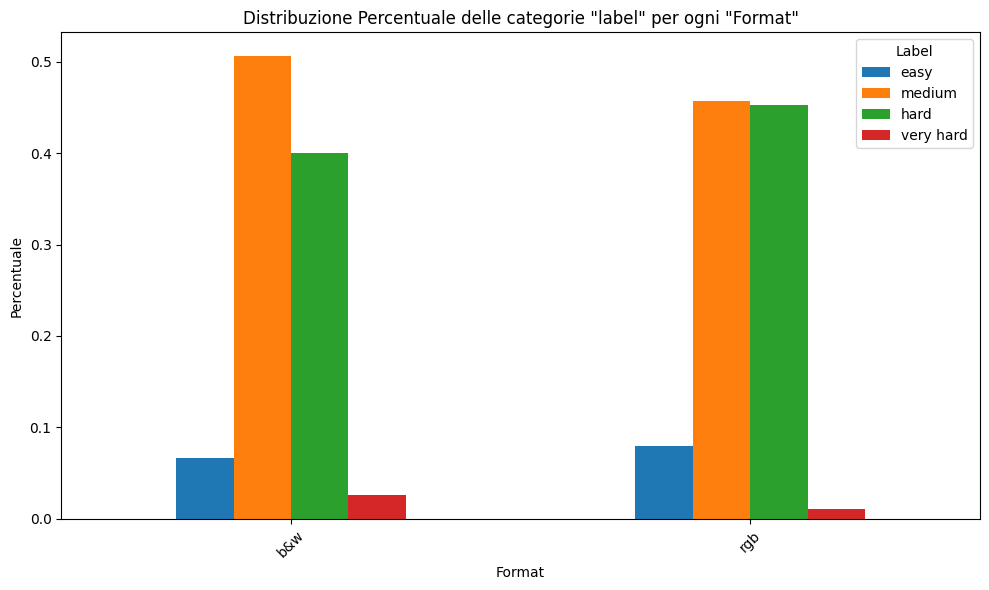

% distribution of labels for each format

label      easy    medium      hard  very hard
b&w    0.066667  0.506667  0.400000   0.026667
rgb    0.079424  0.456823  0.453092   0.010661

--------------------

Count of labels for each format

label   easy  hard  medium  very hard
Format                               
b&w        5    30      38          2
rgb      149   850     857         20


In [431]:
grouped_n = df.groupby('Format')['label'].value_counts(normalize=True).unstack(fill_value=0)
grouped = df.groupby('Format')['label'].value_counts().unstack(fill_value=0)

grouped_n.index = pd.Categorical(grouped_n.index, ordered=True)
grouped_n = grouped_n.sort_index()

grouped_n = grouped_n[order_label]

grouped_n.plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Distribuzione Percentuale delle categorie "label" per ogni "Format"')
plt.xlabel('Format')
plt.ylabel('Percentuale')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right')

plt.tight_layout()
plt.show()

print('% distribution of labels for each format')
print()
print(grouped_n)
print()
print('-'*20)
print()
print('Count of labels for each format')
print()
print(grouped)

In [432]:
bew_df = df[df['Format']=='b&w']
color_df = df[df['Format']=='rgb']

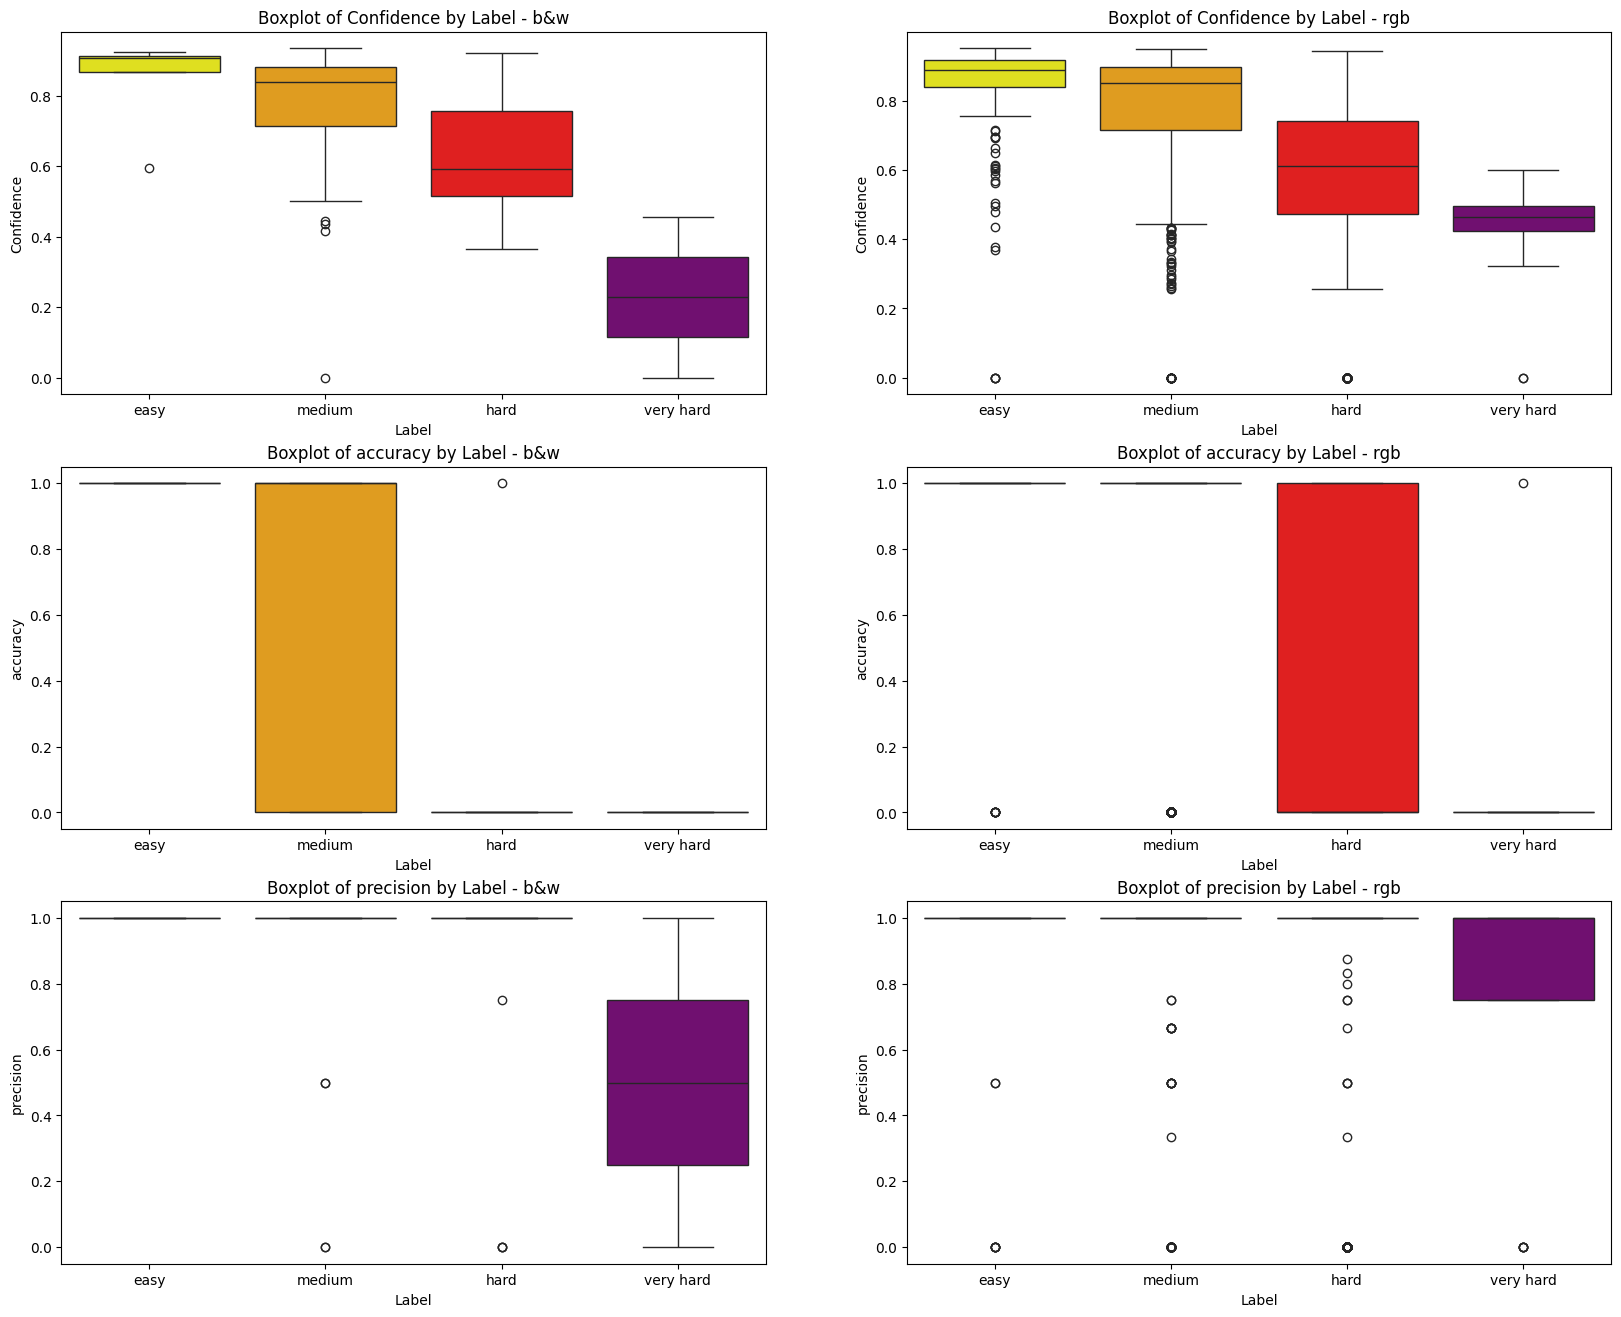

Metrics for B&W
                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.000000   0.000000  1.000000   1.000000  0.000000
hard       2.700000  12.300000  0.033333   0.891667  3.507136
medium     0.421053   0.684211  0.684211   0.921053  0.827170
very hard  6.000000  40.000000  0.000000   0.500000  6.324555

--------------------

Metrics for RGB
                mae        mse  accuracy  precision      rmse
label                                                        
easy       0.053691   0.053691  0.946309   0.953020  0.231714
hard       1.831765   7.330588  0.263529   0.787657  2.707506
medium     0.228705   0.298716  0.803967   0.931544  0.546550
very hard  4.700000  28.100000  0.050000   0.750000  5.300943
--------------------


In [433]:
plt.figure(figsize=(20,16))
plt.subplot(3, 2, 1)
plot_grouped_boxplot(bew_df, 'Confidence', name='b&w', subplot=True)
plt.subplot(3, 2, 2)
plot_grouped_boxplot(color_df, 'Confidence', name='rgb', subplot=True)
plt.subplot(3, 2, 3)
plot_grouped_boxplot(bew_df, 'accuracy', name='b&w', subplot=True)
plt.subplot(3, 2, 4)
plot_grouped_boxplot(color_df, 'accuracy', name='rgb', subplot=True)
plt.subplot(3, 2, 5)
plot_grouped_boxplot(bew_df, 'precision', name='b&w', subplot=True)
plt.subplot(3, 2, 6)
plot_grouped_boxplot(color_df, 'precision', name='rgb', subplot=True)
plt.show()

print('Metrics for B&W')
print(group_df_and_agg_metrics(bew_df))
print()
print('-'*20)
print()

print('Metrics for RGB')
print(group_df_and_agg_metrics(color_df))
print('-'*20)

For easy images we don't have many samples, but b&w looks working quite well. For all the other images, YOLO works worse on B&W images than on RGB images. Especially in the accuracy, reaching, for hard images, only 3%, against 26% of RGB.

## Does cropping influence detection performance?

In [434]:
# All
all_predictions_df = pd.read_csv(f'./data/yolo_prediction/All.csv')

# Top
top25_pred_df = pd.read_csv(f'./data/yolo_prediction/Top25.csv')
top50_pred_df = pd.read_csv(f'./data/yolo_prediction/Top50.csv')
top75_pred_df = pd.read_csv(f'./data/yolo_prediction/Top75.csv')

# Side
side25_pred_df = pd.read_csv(f'./data/yolo_prediction/Side25.csv')
side50_pred_df = pd.read_csv(f'./data/yolo_prediction/Side50.csv')
side75_pred_df = pd.read_csv(f'./data/yolo_prediction/Side75.csv')

In [435]:
# All
single_pred_df = pd.merge(all_predictions_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')

# Top prediction
top25_pred_df = pd.merge(top25_pred_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')
top50_pred_df = pd.merge(top50_pred_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')
top75_pred_df = pd.merge(top75_pred_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')

# Side prediction
side25_pred_df = pd.merge(side25_pred_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')
side50_pred_df = pd.merge(side50_pred_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')
side75_pred_df = pd.merge(side75_pred_df, anns_df[['Img', 'label']], how='inner', left_on='Img_ID', right_on='Img')

In [436]:
top2550_df = pd.merge(top25_pred_df[['ID', 'Confidence']], top50_pred_df[['ID', 'Confidence', 'label']], on='ID', suffixes=('_top25', '_top50'))
top5075_df = pd.merge(top50_pred_df[['ID', 'Confidence']], top75_pred_df[['ID', 'Confidence', 'label']], on='ID', suffixes=('_top50', '_top75'))
top75all_df = pd.merge(top75_pred_df[['ID', 'Confidence']], single_pred_df[['ID', 'Confidence', 'label']], on='ID', suffixes=('_top75', '_all'))

side2550_df = pd.merge(side25_pred_df[['ID', 'Confidence']], side50_pred_df[['ID', 'Confidence', 'label']], on='ID', suffixes=('_side25', '_side50'))
side5075_df = pd.merge(side50_pred_df[['ID', 'Confidence']], side75_pred_df[['ID', 'Confidence', 'label']], on='ID', suffixes=('_side50', '_side75'))
side75all_df = pd.merge(side75_pred_df[['ID', 'Confidence']], single_pred_df[['ID', 'Confidence', 'label']], on='ID', suffixes=('_side75', '_all'))

In [437]:
filter_names = ['all', 'top25', 'top50', 'top75', 'side25', 'side50', 'side75']
comparison = [[1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 0]]
comparison_df_list = [top2550_df, top5075_df, top75all_df, side2550_df, side5075_df, side75all_df]

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scatter_confidence_difference(df, names, ax, legend = False):
    label_palette = {
        'easy': 'blue',    
        'medium': 'green',  
        'hard': 'red',     
        'very hard': 'purple' 
    }

    # Scatter plot on specific axes
    for label, color in label_palette.items():
        subset = df[df['label'] == label]
        ax.scatter(
            subset[f'Confidence_{names[0]}'],
            subset[f'Confidence_{names[1]}'],
            label=label,
            color=color,
            alpha=0.7,
            s=50
        )

    max_value = max(df[f'Confidence_{names[0]}'].max(), df[f'Confidence_{names[1]}'].max())
    ax.plot([0, max_value], [0, max_value], linestyle='--', color='black')

    ax.set_title(f"{names[0]} vs {names[1]}", fontsize=14)
    ax.set_xlabel(f'Confidence {names[0]}', fontsize=10)
    ax.set_ylabel(f'Confidence {names[1]}', fontsize=10)
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
                    handles, labels, title="Label", fontsize=12,
                    loc='upper right', bbox_to_anchor=(1.05, 0.85)
        )    
    ax.grid(alpha=0.5)


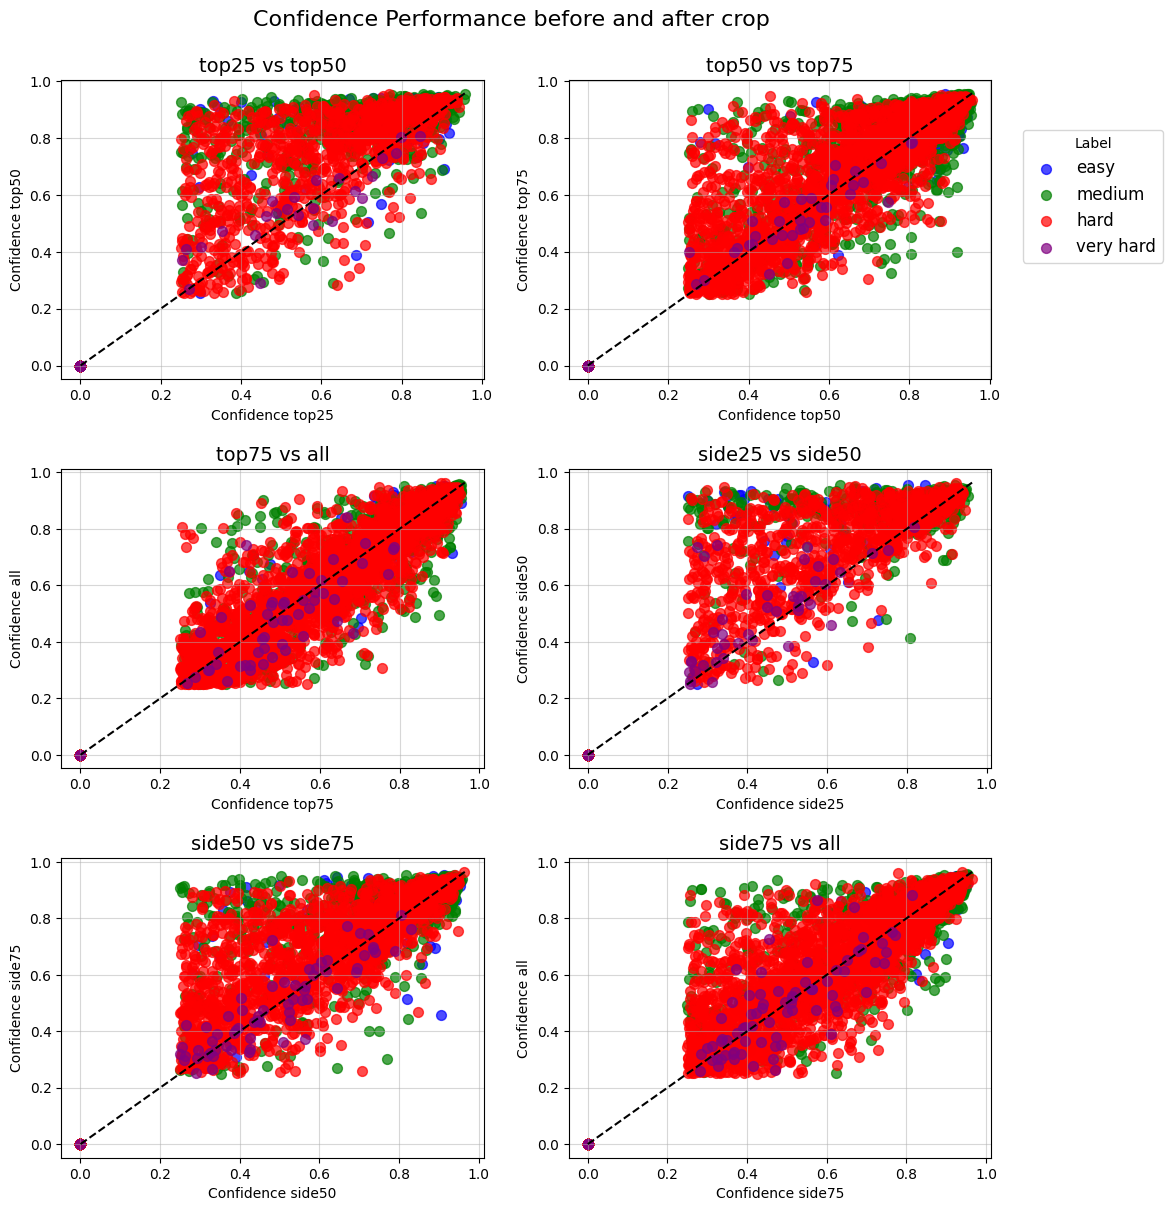

In [439]:
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle(f'Confidence Performance before and after crop', fontsize=16, y=0.93)
for index, (df, couple) in enumerate(zip(comparison_df_list, comparison)):
    legend = True if index==0 else False
    ax = axes[index // 2, index % 2]
    plot_scatter_confidence_difference(df, [filter_names[couple[0]], filter_names[couple[1]]], ax, legend)
plt.subplots_adjust(hspace=0.3) 
# plt.savefig(f'./plots/histograms/{(title.replace(" ", ""))}.png')
plt.show()

In [440]:
df_list[0]

num_people    offset  face_avg_ratio  body_avg_ratio  \
Img                                                            
326              1  0.152845        0.800000        1.000000   
1149            12  0.457257        0.566667        0.510417   
1200             3  0.634782        0.000000        0.000000   
1319             1  0.509654        0.600000        0.500000   
1900             1  0.254233        0.000000        0.000000   
...            ...       ...             ...             ...   
579891           1  0.345929        0.800000        1.000000   
580781           1  0.205454        0.600000        0.750000   
581183          12  0.517451        0.150000        0.416667   
581278           1  0.088761        1.000000        1.000000   
581557           1  0.039613        0.400000        1.000000   

        extremities_avg_ratio  num_people_diff  people_size_diff  \
Img                                                                
326                  0.125000         0.500000          0.777912   
1149                 0.416667         0.923077          0.968225   
1200                 0.000000         0.750000          0.999022   
1319                 0.812500         0.500000          0.946072   
1900                 0.000000         0.500000          0.994862   
...                       ...              ...               ...   
579891               1.000000         0.500000          0.936058   
580781               0.250000         0.500000          0.531672   
581183               0.354167         0.923077          0.993702   
581278               0.500000         0.500000          0.663991   
581557               0.437500         0.500000          0.830860   

        visibility_diff  offset_diff  total_dif  ... Format  true_pos  \
Img                                              ...                    
326            0.275000     0.152845   0.426439  ...    rgb         1   
1149           0.480208     0.457257   0.707192  ...    rgb         9   
1200           1.000000     0.634782   0.845951  ...    rgb         3   
1319           0.387500     0.509654   0.585807  ...    rgb         0   
1900           1.000000     0.254233   0.687274  ...    b&w         0   
...                 ...          ...        ...  ...    ...       ...   
579891         0.100000     0.345929   0.470497  ...    rgb         1   
580781         0.425000     0.205454   0.415531  ...    rgb         1   
581183         0.729167     0.517451   0.790849  ...    rgb         3   
581278         0.100000     0.088761   0.338188  ...    rgb         1   
581557         0.412500     0.039613   0.445743  ...    rgb         1   

        false_pos false_neg  mae  mse  accuracy  precision  recall  f1-score  
Img                                                                           
326             0         0    0    0         1        1.0    1.00  1.000000  
1149            0         3    3    9         0        1.0    0.75  0.857143  
1200            0         0    0    0         1        1.0    1.00  1.000000  
1319            0         1    1    1         0        0.0    0.00  0.000000  
1900            0         1    1    1         0        0.0    0.00  0.000000  
...           ...       ...  ...  ...       ...        ...     ...       ...  
579891          0         0    0    0         1        1.0    1.00  1.000000  
580781          0         0    0    0         1        1.0    1.00  1.000000  
581183          0         9    9   81         0        1.0    0.25  0.400000  
581278          0         0    0    0         1        1.0    1.00  1.000000  
581557          0         0    0    0         1        1.0    1.00  1.000000  

[2001 rows x 23 columns]

### Qualitative Analysis

In [441]:
diff = ['people_size_diff', 'num_people_diff', 'visibility_diff', 'offset_diff', 'total_dif']

In [442]:
precision_0 = df_list[0][df_list[0]['precision']==0]
random_precision_0 = random.sample(list(precision_0.index), 40)
accuracy_0 = df_list[0][df_list[0]['accuracy']==0]
rancom_accuracy_0 = random.sample(list(accuracy_0.index), 40)
confidence_0 = df_list[0][df_list[0]['Confidence']<0.6]
random_confidence_0 = random.sample(list(confidence_0.index), 40)
mae_3 = df_list[0][df_list[0]['mae']>=3]

In [443]:
def comparison_diff(ax, df1, df2, n1, n2, diff, color):
    df1[f'{diff}'].plot(kind='kde', color='blue', label=n1, ax=ax) 
    df2[f'{diff}'].plot(kind='kde', color=f'{color}', label=n2, ax=ax) 

    ax.set_xlabel(diff)
    ax.set_ylabel('Density') 
    ax.set_title(f'Density of {diff}')
    ax.legend()
    if diff != 'num_people_diff':
        ax.set_xlim(0, 1.1)

In [444]:
def add_category_distribution(ax, df1, df2, n1, n2, color):

    original_counts = df1['label'].value_counts(normalize=True)  
    precision_counts = df2['label'].value_counts(normalize=True)

    categories = ['easy', 'medium', 'hard']
    comparison_df = pd.DataFrame({
        n1: [original_counts.get(cat, 0) for cat in categories],
        n2: [precision_counts.get(cat, 0) for cat in categories]
    }, index=categories)

    comparison_df.plot(kind='bar', ax=ax, color=['blue', f'{color}'], width=0.4, position=1)

    ax.set_title('Category Distribution: Easy, Medium, Hard')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

### Precision

#### Examples of Precision 0 images
- 446799 - small size, low contrast
- 317679 - small size, edge, out of focus
- 542582 - small size, covered by object
- 454789 - small size, at edge. low contrast
- 167456 - many people, all very small size, some low contrast
- 407053 - very small size
- 20273 - very low contrast
- 224592 - very small size, only head visible
- 393419 - very small size, at bottom edge
- 389081 - at edge, only part of the hand visible
- 501294 - very low focus
- 42415 - small size, only part of the shirt visible
- 75362 - very small size, at edge
- 6789 - very small size, very low contrast
- 12230 - very small size
- 363716 - very low focus and contrast
- 211811 - very small size, only head visible
- 170953 - 2 people, very small size, only head visible, low contrast
- 263582 - low contrast
- 18775 - innatural pose, not parts of the naked skin visible
- 256607 - multiple people, very small size
- 572884 - low contrast
- 205724 - edge, not associable with Precision
- 283928 - only little part of tissue
- 105781 - at edge, small size, very low contrast
- 521874 - small size, low contrast
- 513796 - small size, low contrast
- 534194 - small size
- 91057 - only little part of leg, not identifiable
- 352899 - small size, very low contrast
- 128395 - very small size, low contrast
- 433221 - only small part of the leg
- 19185 - small size, covered by object
- 264718 - very small size
- 516775 - very small size, very low contrast
- 422289 - many people, very small size
- 323717 - only part of the shoe
- 212122 - very small size
- 139586 - very small size
- 456656 - very low contrast

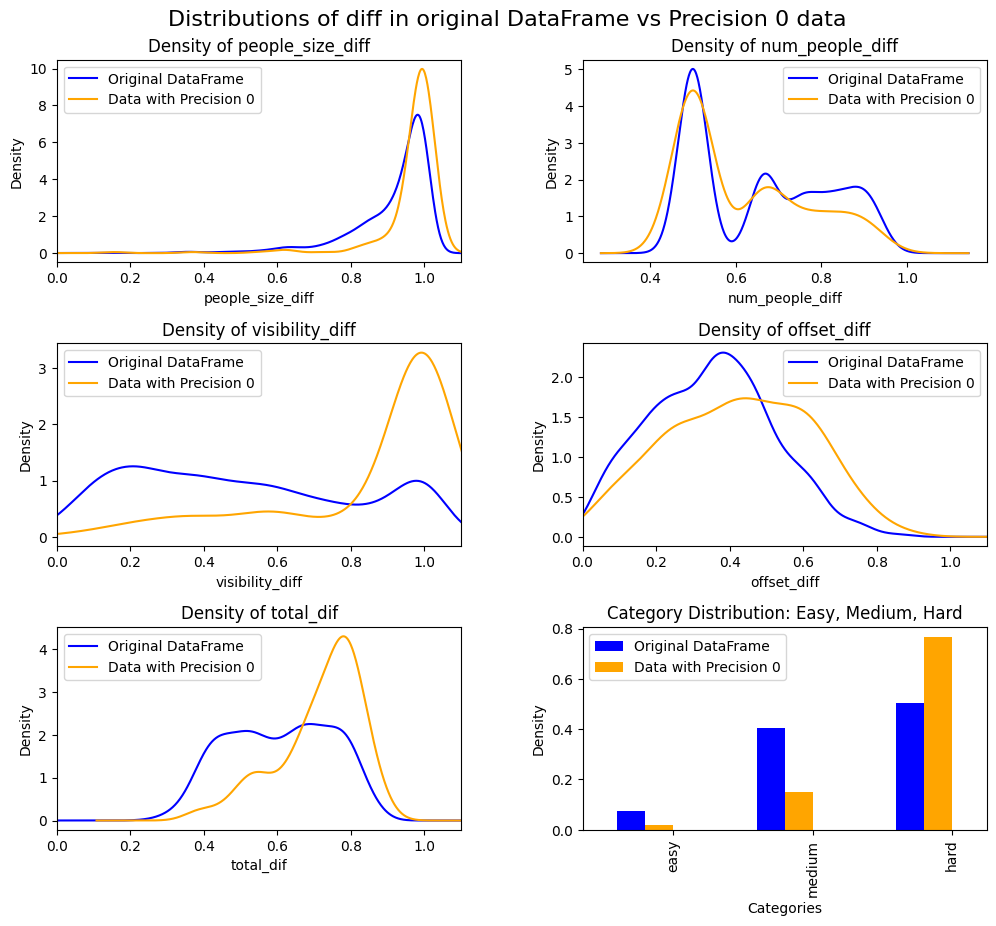

In [445]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 
fig.suptitle('Distributions of diff in original DataFrame vs Precision 0 data', fontsize=16, y=0.93)

for index, dif in enumerate(diff):
    ax = axes[index // 2, index % 2] 
    comparison_diff(ax, df_list[0], precision_0, 'Original DataFrame', 'Data with Precision 0', dif, 'orange')

plt.subplots_adjust(hspace=0.3)  
ax = axes[-1, -1]  

add_category_distribution(ax, df_list[0], precision_0, 'Original DataFrame', 'Data with Precision 0', 'orange')


plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()

### Accuracy

#### Examples of Accuracy 0 images:
- 327804 - low contrast
- 451101 - low contrast
- 290584 - many people, some covered
- 35995 - many people, some covered
- 458248 - very small and at edge
- 477537 - some small and covered
- 243728 - very small
- 418523 - low contrast, some covered
- 392924 - very small
- 359314 - low contrast, part covered
- 172686 - small part, not detectable
- 81971 - many people, some covered
- 323218 - small, out of focus
- 332158 - many people, low contrast
- 289746 - out of focus, covered
- 501443 - low contrast, only partially visible
- 279022 - many people, some covered
- 562876 - many people, some covered
- 39022 - low contrast
- 468420 - out of focus, covered
- 24842 - very small, covered, only little part visible
- 386537 - small, only part of shoes visible
- 357456 - out of focus
- 367549 - very small, many people, low contrast
- 364361 - many people, some covered
- 354878 - very small

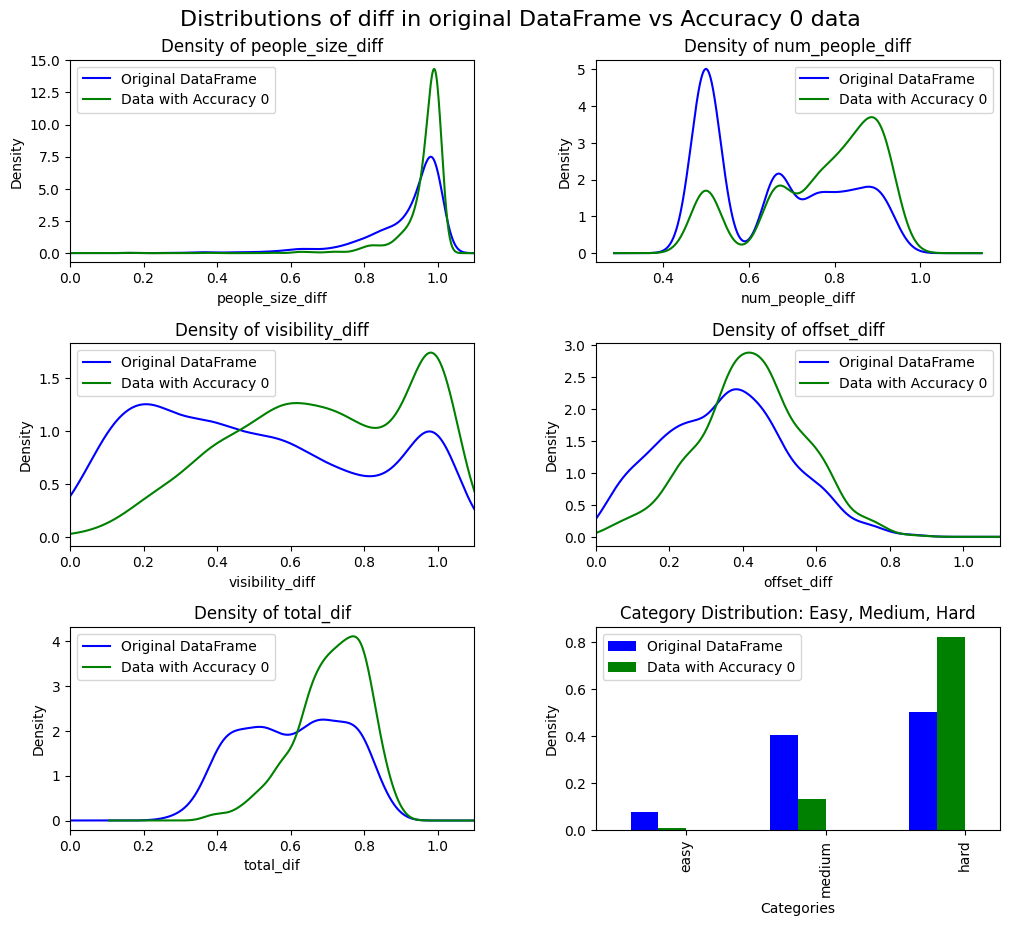

In [446]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 
fig.suptitle('Distributions of diff in original DataFrame vs Accuracy 0 data', fontsize=16, y=0.93)

for index, dif in enumerate(diff):
    ax = axes[index // 2, index % 2] 
    comparison_diff(ax, df_list[0], accuracy_0, 'Original DataFrame', 'Data with Accuracy 0', dif, 'green')

plt.subplots_adjust(hspace=0.3)  
ax = axes[-1, -1]  

add_category_distribution(ax, df_list[0], accuracy_0, 'Original DataFrame', 'Data with Accuracy 0', 'green')


plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()

### Confidence

#### Examples of images with confidence < 0.6
- 358085 - small size
- 380395 - partially visible, out of focus
- 173797 - small size, low contrast
- 305985 - small size, partially visible
- 434192 - very small size, low contrast
- 535604 - small size, low contrast
- 477459 - low contrast
- 36421 - small size, covered, partially visible
- 561390 - many people, small size
- 9095 - partially visible (not head)
- 271359 - many people, covered
- 16346 - small size, covered
- 516775 - very small size
- 438855 - very small size
- 191984 - only little part visible
- 37169 - many people, some covered
- 137042 - many people, low contrast
- 95383 - out of focus, partially covered
- 502232 - out of focus, partially covered
- 144538 - out of focus -->

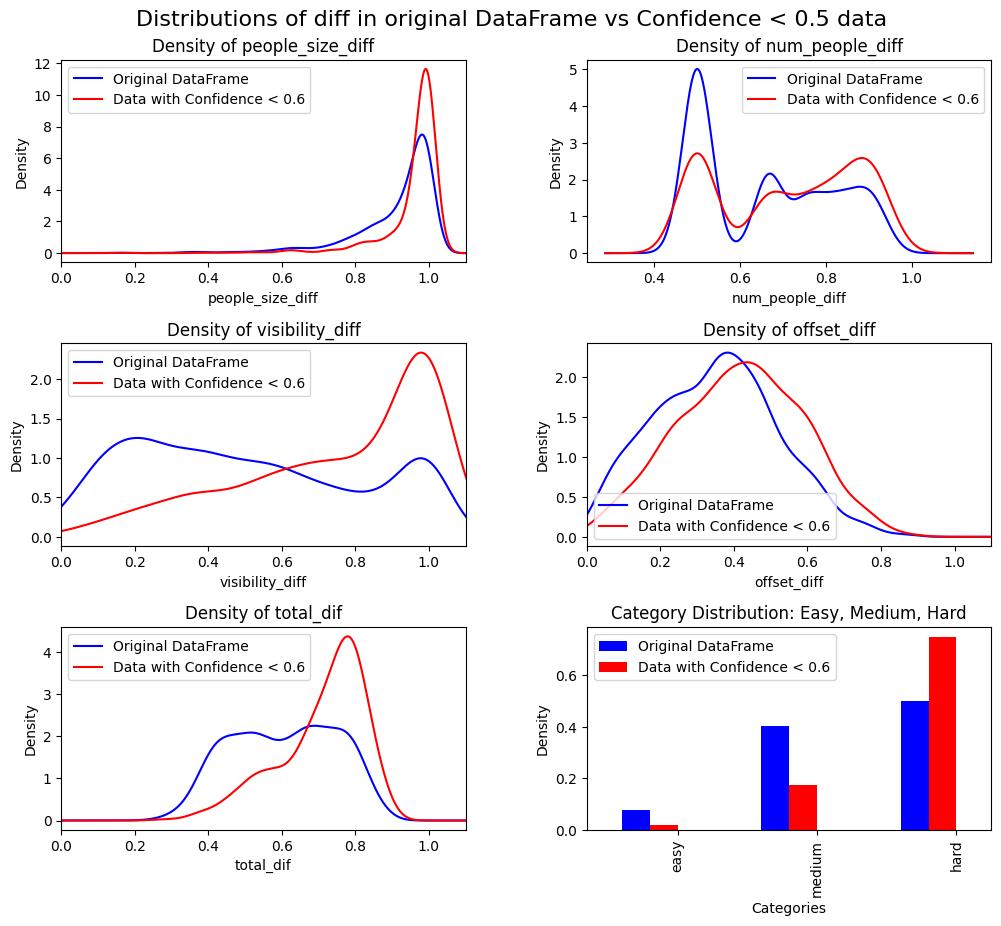

In [447]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 
fig.suptitle('Distributions of diff in original DataFrame vs Confidence < 0.5 data', fontsize=16, y=0.93)

for index, dif in enumerate(diff):
    ax = axes[index // 2, index % 2] 
    comparison_diff(ax, df_list[0], confidence_0, 'Original DataFrame', 'Data with Confidence < 0.6', dif, 'red')

plt.subplots_adjust(hspace=0.3)  
ax = axes[-1, -1]  

add_category_distribution(ax, df_list[0], confidence_0, 'Original DataFrame', 'Data with Confidence < 0.6', 'red')


plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()

### MAE

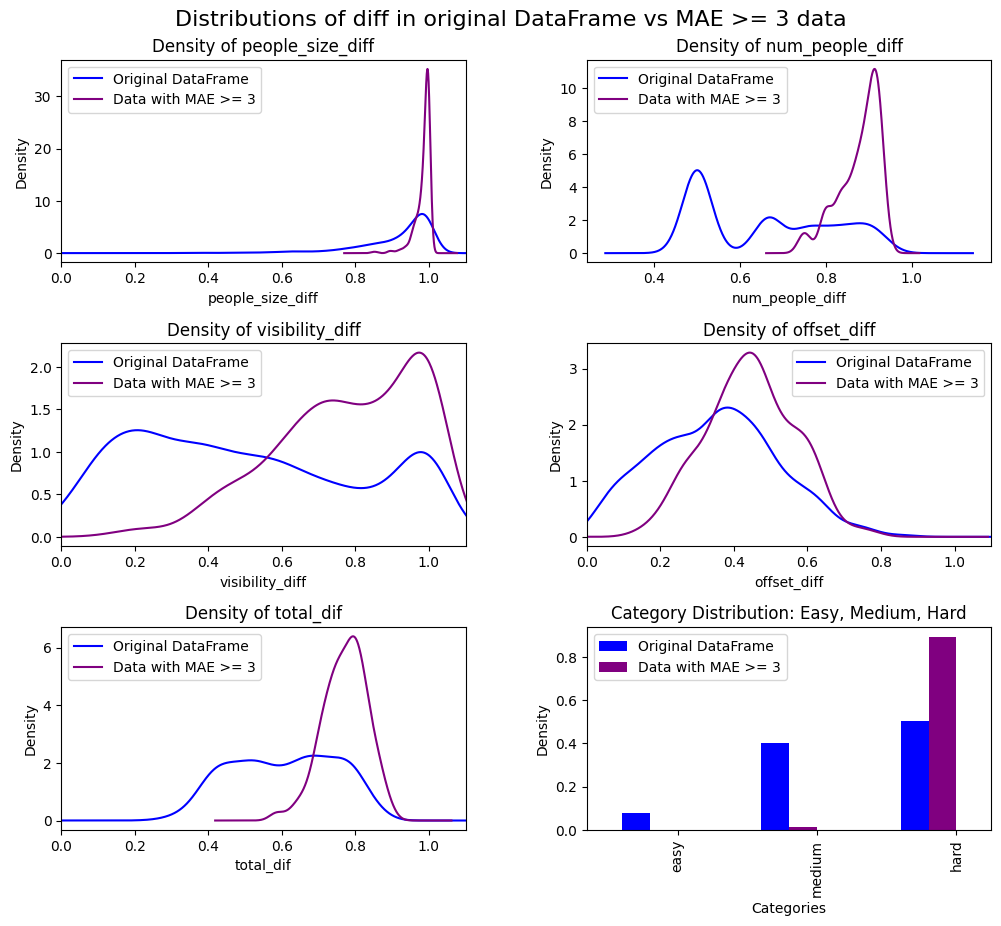

In [448]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 
fig.suptitle('Distributions of diff in original DataFrame vs MAE >= 3 data', fontsize=16, y=0.93)

for index, dif in enumerate(diff):
    ax = axes[index // 2, index % 2] 
    comparison_diff(ax, df_list[0], mae_3, 'Original DataFrame', 'Data with MAE >= 3', dif, 'purple')

plt.subplots_adjust(hspace=0.3)  
ax = axes[-1, -1]  

add_category_distribution(ax, df_list[0], mae_3, 'Original DataFrame', 'Data with MAE >= 3', 'purple')


plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()

In [449]:
df_list[0][df_list[0]['mae']>5]

num_people    offset  face_avg_ratio  body_avg_ratio  \
Img                                                            
2764            13  0.597537        0.000000        0.000000   
3532            12  0.453798        0.166667        0.312500   
4359            13  0.374598        0.146154        0.375000   
10701           10  0.477761        0.250000        0.400000   
16346           10  0.390472        0.380000        0.475000   
...            ...       ...             ...             ...   
566261           8  0.216249        0.400000        0.250000   
572036          11  0.362965        0.209091        0.420455   
572276          11  0.577980        0.072727        0.090909   
573786          10  0.532147        0.250000        0.262500   
581183          12  0.517451        0.150000        0.416667   

        extremities_avg_ratio  num_people_diff  people_size_diff  \
Img                                                                
2764                 0.000000         0.928571          0.999813   
3532                 0.286458         0.923077          0.983489   
4359                 0.379808         0.928571          0.986115   
10701                0.318750         0.909091          0.992451   
16346                0.375000         0.909091          0.991005   
...                       ...              ...               ...   
566261               0.281250         0.888889          0.994723   
572036               0.278409         0.916667          0.983203   
572276               0.079545         0.916667          0.998214   
573786               0.068750         0.909091          0.958974   
581183               0.354167         0.923077          0.993702   

        visibility_diff  offset_diff  total_dif  ... Format  true_pos  \
Img                                              ...                    
2764           1.000000     0.597537   0.881480  ...    rgb         0   
3532           0.765625     0.453798   0.781497  ...    rgb         6   
4359           0.738462     0.374598   0.756936  ...    rgb         5   
10701          0.691250     0.477761   0.767638  ...    rgb         4   
16346          0.592500     0.390472   0.720767  ...    rgb         3   
...                 ...          ...        ...  ...    ...       ...   
566261         0.668750     0.216249   0.692153  ...    rgb         1   
572036         0.713636     0.362965   0.744118  ...    rgb         4   
572276         0.920455     0.577980   0.853329  ...    rgb         2   
573786         0.782500     0.532147   0.795678  ...    rgb         4   
581183         0.729167     0.517451   0.790849  ...    rgb         3   

        false_pos false_neg  mae  mse  accuracy  precision    recall  f1-score  
Img                                                                             
2764            0        13   13  169         0        0.0  0.000000  0.000000  
3532            0         6    6   36         0        1.0  0.500000  0.666667  
4359            0         8    8   64         0        1.0  0.384615  0.555556  
10701           0         6    6   36         0        1.0  0.400000  0.571429  
16346           0         7    7   49         0        1.0  0.300000  0.461538  
...           ...       ...  ...  ...       ...        ...       ...       ...  
566261          0         7    7   49         0        1.0  0.125000  0.222222  
572036          0         7    7   49         0        1.0  0.363636  0.533333  
572276          0         9    9   81         0        1.0  0.181818  0.307692  
573786          0         6    6   36         0        1.0  0.400000  0.571429  
581183          0         9    9   81         0        1.0  0.250000  0.400000  

[129 rows x 23 columns]

### To show - often images with horizontal people -> cropped 

In [450]:
side25_pred_df[side25_pred_df['label']=='easy']

ID  Img_ID  Confidence Format  x_center  y_center     width  \
28      63930    6393    0.606377    rgb  0.505358  0.496145  0.989284   
29       6662    6662    0.000000    rgb       NaN       NaN       NaN   
30       6664    6664    0.000000    rgb       NaN       NaN       NaN   
35      88090    8809    0.497587    rgb  0.888553  0.726769  0.216361   
56     121820   12182    0.852857    rgb  0.500000  0.571993  1.000000   
...       ...     ...         ...    ...       ...       ...       ...   
2558   572008  572008    0.000000    rgb       NaN       NaN       NaN   
2600   578427  578427    0.000000    rgb       NaN       NaN       NaN   
2603  5797980  579798    0.373315    rgb  0.703554  0.851790  0.579379   
2604  5797981  579798    0.320818    rgb  0.689991  0.558943  0.620017   
2608   581278  581278    0.000000    rgb       NaN       NaN       NaN   

        height     Img label  
28    0.989447    6393  easy  
29         NaN    6662  easy  
30         NaN    6664  easy  
35    0.141492    8809  easy  
56    0.852748   12182  easy  
...        ...     ...   ...  
2558       NaN  572008  easy  
2600       NaN  578427  easy  
2603  0.293799  579798  easy  
2604  0.845362  579798  easy  
2608       NaN  581278  easy  

[162 rows x 10 columns]

## Comparison between cropped and filled

In [451]:
top25_pred_df

ID  Img_ID  Confidence Format  x_center  y_center     width  \
0         326     326    0.000000    rgb       NaN       NaN       NaN   
1       11490    1149    0.740454    rgb  0.934574  0.659352  0.128485   
2       11491    1149    0.691698    rgb  0.847224  0.700364  0.085687   
3       11492    1149    0.682288    rgb  0.250478  0.722712  0.146002   
4       11493    1149    0.679776    rgb  0.554702  0.589482  0.118564   
...       ...     ...         ...    ...       ...       ...       ...   
2904  5807810  580781    0.828518    rgb  0.747581  0.493372  0.498756   
2905  5811830  581183    0.307154    rgb  0.697513  0.853874  0.066523   
2906  5811831  581183    0.258612    rgb  0.621157  0.783840  0.051183   
2907  5812780  581278    0.868160    rgb  0.502285  0.548572  0.519399   
2908  5815570  581557    0.492285    rgb  0.499827  0.500000  0.603196   

        height     Img   label  
0          NaN     326  medium  
1     0.681295    1149    hard  
2     0.599271    1149    hard  
3     0.554575    1149    hard  
4     0.816986    1149    hard  
...        ...     ...     ...  
2904  0.947808  580781  medium  
2905  0.288609  581183    hard  
2906  0.412151  581183    hard  
2907  0.884365  581278    easy  
2908  1.000000  581557  medium  

[2909 rows x 10 columns]

In [452]:
top25_cropped = pd.read_csv('data/yolo_prediction/Top25_filled.csv')
top50_cropped = pd.read_csv('data/yolo_prediction/Top50_filled.csv')
top75_cropped = pd.read_csv('data/yolo_prediction/Top75_filled.csv')
side25_cropped = pd.read_csv('data/yolo_prediction/Side25_filled.csv')
side50_cropped = pd.read_csv('data/yolo_prediction/Side50_filled.csv')
side75_cropped = pd.read_csv('data/yolo_prediction/Side75_filled.csv')

### Top 25

In [453]:
top25_join = pd.merge(top25_pred_df, top25_cropped, on='ID', how='outer')
top25_join = top25_join.fillna(0)

In [454]:
print(len(top25_join[top25_join['Confidence_x']!=top25_join['Confidence_y']]))
print(len(top25_join))

8
2961


In [455]:
top25_join[top25_join['Confidence_x']!=top25_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]

ID  Img_ID_y  Confidence_x  Confidence_y
1134   542600     54260           0.0      0.345124
1219   581430     58143           0.0      0.738841
1300   778060     77806           0.0      0.647552
1301   778061     77806           0.0      0.444669
1991  2996880    299688           0.0      0.827743
2274  3890810    389081           0.0      0.333804
2275  3890811    389081           0.0      0.313035
2899  5696180    569618           0.0      0.342536

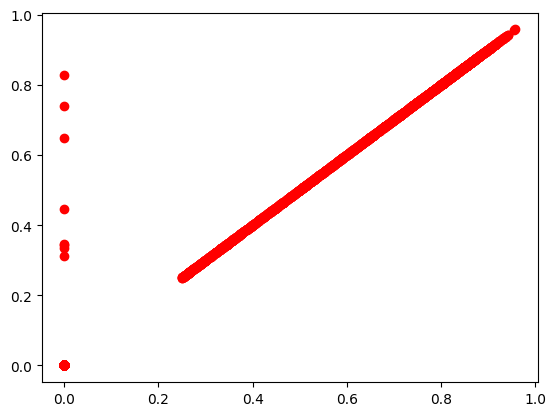

In [456]:
plt.scatter(top25_join['Confidence_x'], top25_join['Confidence_y'], color='red')

### Top 50

In [457]:
top50_join = pd.merge(top50_pred_df, top50_cropped, on='ID', how='outer')
top50_join = top50_join.fillna(0)

In [458]:
print(len(top50_join[top50_join['Confidence_x']!=top50_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]))
print(len(top50_join))

22
4613


In [459]:
top50_join[top50_join['Confidence_x']!=top50_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]

ID  Img_ID_y  Confidence_x  Confidence_y
689    542600     54260           0.0      0.535093
690    542601     54260           0.0      0.317496
746    581430     58143           0.0      0.898053
747    581431     58143           0.0      0.444175
754    589280     58928           0.0      0.490354
755    589281     58928           0.0      0.323627
918    778060     77806           0.0      0.757712
1001   949960     94996           0.0      0.776735
1002   949961     94996           0.0      0.323148
1062  1066610    106661           0.0      0.298034
1203  1276710    127671           0.0      0.333272
1392  1553560    155356           0.0      0.714259
1393  1553561    155356           0.0      0.549909
1464  1720210    172021           0.0      0.758361
1465  1720211    172021           0.0      0.425610
2370  2996880    299688           0.0      0.875485
2514  3222680    322268           0.0      0.847716
2830  3579300    357930           0.0      0.862847
2831  3579301    357930           0.0      0.250301
3075  3890810    389081           0.0      0.348934
4150  5367080    536708           0.0      0.655401
4442  5696180    569618           0.0      0.461380

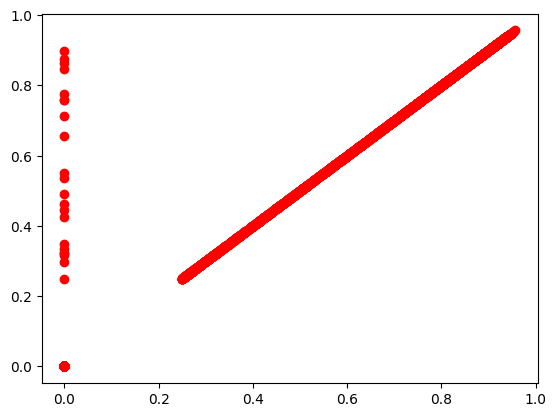

In [460]:
plt.scatter(top50_join['Confidence_x'], top50_join['Confidence_y'], color='red')

### Top 75

In [461]:
top75_join = pd.merge(top75_pred_df, top75_cropped, on='ID', how='outer')
top75_join = top75_join.fillna(0)

In [462]:
print(len(top75_join[top75_join['Confidence_x']!=top75_join['Confidence_y']]))
print(len(top75_join))

59
5558


In [463]:
top75_join[top75_join['Confidence_x']!=top75_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]

ID  Img_ID_y  Confidence_x  Confidence_y
94      81870      8187           0.0      0.398149
95      81871      8187           0.0      0.287114
307    258330     25833           0.0      0.925567
356    297610     29761           0.0      0.538297
357    297611     29761           0.0      0.387099
474    400650     40065           0.0      0.491247
603    542600     54260           0.0      0.322517
604    542601     54260           0.0      0.321896
633    569830     56983           0.0      0.308715
644    581430     58143           0.0      0.890633
645    581431     58143           0.0      0.417729
646    581432     58143           0.0      0.256034
660    589280     58928           0.0      0.547024
726    651950     65195           0.0      0.793613
852    778060     77806           0.0      0.708796
963    949960     94996           0.0      0.857124
964    949961     94996           0.0      0.266290
1037  1066610    106661           0.0      0.311054
1184  1241240    124124           0.0      0.753590
1209  1276710    127671           0.0      0.331424
1348  1453610    145361           0.0      0.323871
1437  1553560    155356           0.0      0.781243
1438  1553561    155356           0.0      0.690194
1439  1553562    155356           0.0      0.442399
1501  1676710    167671           0.0      0.503840
1502  1676711    167671           0.0      0.361845
1531  1720210    172021           0.0      0.896523
1532  1720211    172021           0.0      0.320899
1715  1941880    194188           0.0      0.650981
1903  2147590    214759           0.0      0.442379
2576  2870030    287003           0.0      0.572247
2604  2904850    290485           0.0      0.382900
2699  2996880    299688           0.0      0.906672
2885  3222680    322268           0.0      0.835363
3260  3579300    357930           0.0      0.879227
3550  3890810    389081           0.0      0.399011
3551  3893360    389336           0.0      0.756349
3724  4068670    406867           0.0      0.441104
4061  4415320    441532           0.0      0.901879
4062  4415321    441532           0.0      0.401025
4063  4415322    441532           0.0      0.370939
4613  4970960    497096           0.0      0.325716
4691  5058580    505858           0.0      0.568585
4782  5167750    516775           0.0      0.611309
4803  5191460    519146           0.0      0.643130
4804  5191461    519146           0.0      0.447519
4805  5191462    519146           0.0      0.300640
4806  5191463    519146           0.0      0.289136
4807  5191464    519146           0.0      0.285352
4808  5191465    519146           0.0      0.271334
4809  5191466    519146           0.0      0.264010
4810  5191467    519146           0.0      0.260368
4951  5367080    536708           0.0      0.687616
4960  5370660    537066           0.0      0.706382
4961  5370661    537066           0.0      0.567943
4962  5370662    537066           0.0      0.507565
4963  5370663    537066           0.0      0.452207
4964  5370664    537066           0.0      0.430638
5320  5696180    569618           0.0      0.470102

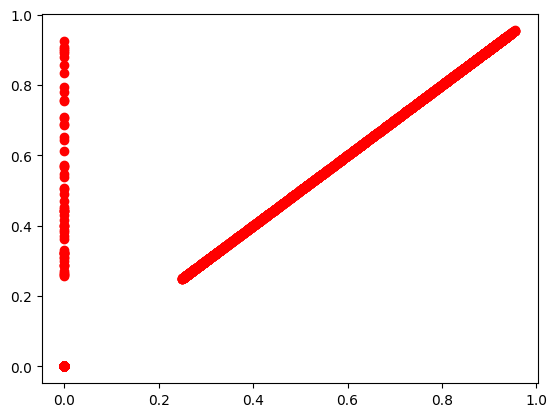

In [464]:
plt.scatter(top75_join['Confidence_x'], top75_join['Confidence_y'], color='red')

### Side 25

In [465]:
side25_join = pd.merge(side25_pred_df, side25_cropped, on='ID', how='outer')
side25_join = side25_join.fillna(0)

In [466]:
print(len(side25_join[side25_join['Confidence_x']!=side25_join['Confidence_y']]))
print(len(side25_join))

1
2660


In [467]:
side25_join[side25_join['Confidence_x']!=side25_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]

ID  Img_ID_y  Confidence_x  Confidence_y
2467  5167750    516775           0.0      0.390524

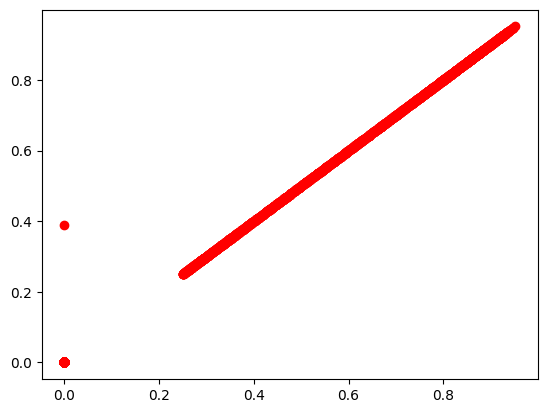

In [468]:
plt.scatter(side25_join['Confidence_x'], side25_join['Confidence_y'], color='red')

### Side 50

In [469]:
side50_join = pd.merge(side50_pred_df, side50_cropped, on='ID', how='outer')
side50_join = side50_join.fillna(0)

In [470]:
print(len(side50_join[side50_join['Confidence_x']!=side50_join['Confidence_y']]))
print(len(side50_join))

2
3762


In [471]:
side50_join[side50_join['Confidence_x']!=side50_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]

ID  Img_ID_y  Confidence_x  Confidence_y
816  753620     75362           0.0      0.424434
917  949960     94996           0.0      0.409320

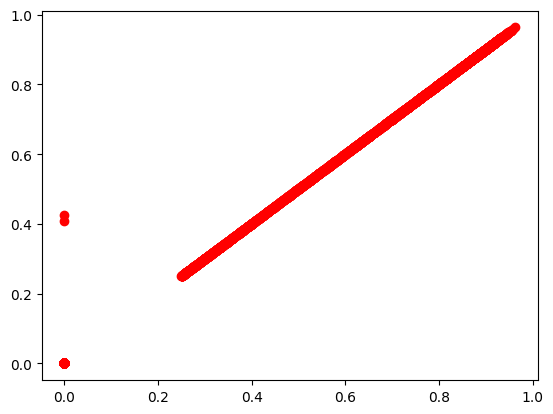

In [472]:
plt.scatter(side50_join['Confidence_x'], side50_join['Confidence_y'], color='red')

### Side 75

In [473]:
side75_join = pd.merge(side75_pred_df, side75_cropped, on='ID', how='outer')
side75_join = side75_join.fillna(0)

In [474]:
print(len(side75_join[side75_join['Confidence_x']!=side75_join['Confidence_y']]))
print(len(side75_join))

7
4938


In [475]:
side75_join[side75_join['Confidence_x']!=side75_join['Confidence_y']][['ID', 'Img_ID_y', 'Confidence_x', 'Confidence_y']]

ID  Img_ID_y  Confidence_x  Confidence_y
760    753620     75362           0.0      0.255125
883    949960     94996           0.0      0.253007
982   1138010    113801           0.0      0.375126
1105  1276710    127671           0.0      0.273564
1398  1720210    172021           0.0      0.251946
2196  2757580    275758           0.0      0.276767
3149  3819940    381994           0.0      0.559579

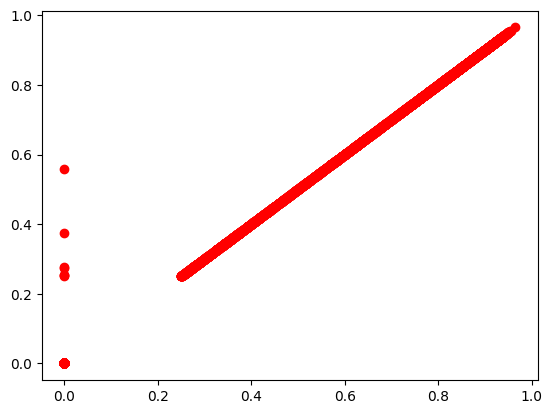

In [476]:
plt.scatter(side75_join['Confidence_x'], side75_join['Confidence_y'], color='red')

## Analysis of keypoints presence related to confidence

In [477]:
single_anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [478]:
single_anns_df = single_anns_df.rename({'vis_face_ratio': 'head', 'vis_body_ratio': 'torso'}, axis=1)

In [479]:
single_anns_df['foot'] = (single_anns_df['left_ankle_v'] + single_anns_df['right_ankle_v'])/2
single_anns_df['legs'] = (single_anns_df['left_knee_v'] + single_anns_df['right_knee_v'])/2
single_anns_df['arms'] = (single_anns_df['left_elbow_v'] + single_anns_df['right_elbow_v'])/2
single_anns_df['hand'] = (single_anns_df['left_wrist_v'] + single_anns_df['right_wrist_v'])/2
single_anns_df['legs'] = (single_anns_df['left_knee_v'] + single_anns_df['right_knee_v'])/2
single_anns_df['eyes'] = (single_anns_df['left_eye_v'] + single_anns_df['right_eye_v'])/2

In [480]:
single_anns_df['width'] = single_anns_df['width']/single_anns_df['img_width']
single_anns_df['height'] = single_anns_df['height']/single_anns_df['img_height']

In [504]:
single_anns_df['ID'] = (single_anns_df['Img'].astype(str) + (single_anns_df['person_num']-1).astype(str)).astype(int)

In [499]:
single_anns_df = single_anns_df[['ID', 'Img', 'person_num', 'area_norm', 'img_width', 'img_height', 'x', 'y', 'width', 'height', 'foot', 'legs', 'arms', 'eyes', 'head', 'hand', 'torso']]

In [483]:
single_pred_df = all_predictions_df.copy()

In [484]:
single_pred_df['x_pred'] = np.maximum(single_pred_df['x_center']-(single_pred_df['width'])/2, 0) # To avoid < 0 for rounding errors
single_pred_df['y_pred'] = np.maximum(single_pred_df['y_center']-(single_pred_df['height'])/2, 0) # To avoid < 0 for round errors

In [485]:
single_pred_df = single_pred_df[['ID', 'Img_ID', 'Confidence', 'x_pred', 'y_pred', 'width', 'height']]
single_pred_df = single_pred_df.rename({'width': 'width_pred', 'height': 'height_pred'}, axis=1)

In [486]:
single_anns_df['x'] = single_anns_df['x']/single_anns_df['img_width']
single_anns_df['y'] = single_anns_df['y']/single_anns_df['img_height']

In [487]:
single_merged = pd.merge(single_anns_df, single_pred_df, left_on='Img', right_on='Img_ID', how='inner')

In [488]:
def calculate_iou_vectorized(df):
    x1_inter = df[['x', 'x_pred']].max(axis=1)
    y1_inter = df[['y', 'y_pred']].max(axis=1)
    x2_inter = (df['x'] + df['width']).clip(upper=(df['x_pred'] + df['width_pred']))
    y2_inter = (df['y'] + df['height']).clip(upper=(df['y_pred'] + df['height_pred']))

    inter_width = (x2_inter - x1_inter).clip(lower=0)
    inter_height = (y2_inter - y1_inter).clip(lower=0)
    intersection = inter_width * inter_height

    area_coco = df['width'] * df['height']
    area_yolo = df['width_pred'] * df['height_pred']
    union = area_coco + area_yolo - intersection

    return intersection / union 

In [521]:
single_merged['IoU'] = calculate_iou_vectorized(single_merged)

result_df = single_merged[single_merged['IoU'] > 0.5].drop_duplicates(subset='ID', keep='first')
result_df[['ID', 'Img', 'Confidence', 'foot', 'head', 'torso', 'legs', 'arms', 'eyes', 'hand']]

ID     Img  Confidence  foot  head  torso  legs  arms  eyes  hand
0      5224180  522418    0.778439   0.0   0.6  0.250   0.0  0.50   0.5  0.00
2      1289391  128939    0.482966   0.0   0.0  0.375   0.0  0.50   0.0  0.00
8      1289393  128939    0.324429   0.0   0.0  0.000   0.0  0.00   0.0  0.00
13     1289390  128939    0.615011   0.0   0.0  0.500   0.0  0.50   0.0  0.50
15     1289392  128939    0.387029   0.0   0.0  0.500   0.0  0.50   0.0  0.50
...        ...     ...         ...   ...   ...    ...   ...   ...   ...   ...
31345  3574560  357456    0.875804   0.0   1.0  1.000   0.0  1.00   1.0  1.00
31349  3574561  357456    0.359971   0.0   1.0  0.125   0.0  0.00   1.0  0.00
31350  3574562  357456    0.274657   0.0   1.0  0.125   0.0  0.00   1.0  0.00
31352  5160491  516049    0.488207   0.0   0.6  0.625   0.5  0.50   0.5  1.00
31353  5160490  516049    0.832465   0.0   0.6  0.875   0.0  0.25   0.5  0.75

[4848 rows x 10 columns]

In [522]:
def create_not_visible_df(df, partial = False):
    not_visible_parts_df = []
    included_indices = set()
    body_parts = ['head', 'head-torso', 'head-legs', 'eyes', 'eyes-torso', 'arms', 'torso',  'torso-legs', 'legs', 'hand', 'foot']
    for part in body_parts:
        if '-' in part:
            parts = part.split('-')
            if partial:
                temp_df = df[((df[parts[0]] > 0) & (df[parts[0]] < 1)) & ((df[parts[1]] > 0) & (df[parts[1]] < 1))].copy()
            else:
                temp_df = df[(df[parts[0]] == 0) & (df[parts[1]] == 0)].copy()
        else:
            if partial:
                temp_df = df[((df[part] > 0) & (df[part] < 1))].copy()
            else:
                temp_df = df[df[part] == 0].copy()
            
        temp_df['Feature'] = part
        not_visible_parts_df.append(temp_df)
        included_indices.update(temp_df.index)

    if not partial:
        remaining_df = result_df[~result_df.index.isin(included_indices)][['Confidence']].copy()
        remaining_df.loc[:, 'Feature'] = 'None'
        not_visible_parts_df.append(remaining_df)
    return not_visible_parts_df

C:\Users\fedep\AppData\Local\Temp\ipykernel_14580\424371595.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Feature', y='Confidence', palette='coolwarm')


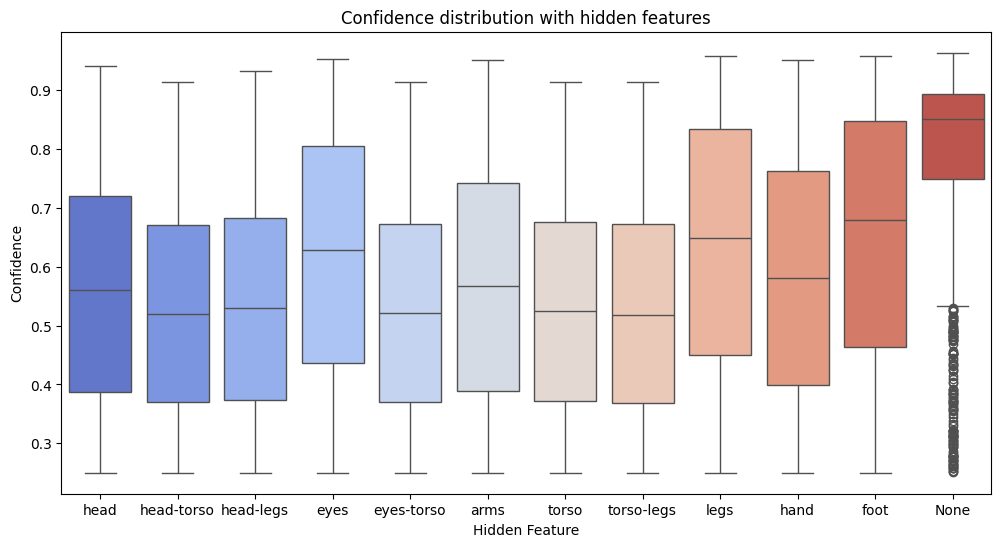

In [523]:
not_visible_parts_df = create_not_visible_df(result_df)
plot_df = pd.concat(not_visible_parts_df, axis=0)

plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Feature', y='Confidence', palette='coolwarm')

plt.title("Confidence distribution with hidden features")
plt.xlabel("Hidden Feature")
plt.ylabel("Confidence")
plt.show()

C:\Users\fedep\AppData\Local\Temp\ipykernel_14580\526296107.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Feature', y='Confidence', palette='coolwarm')


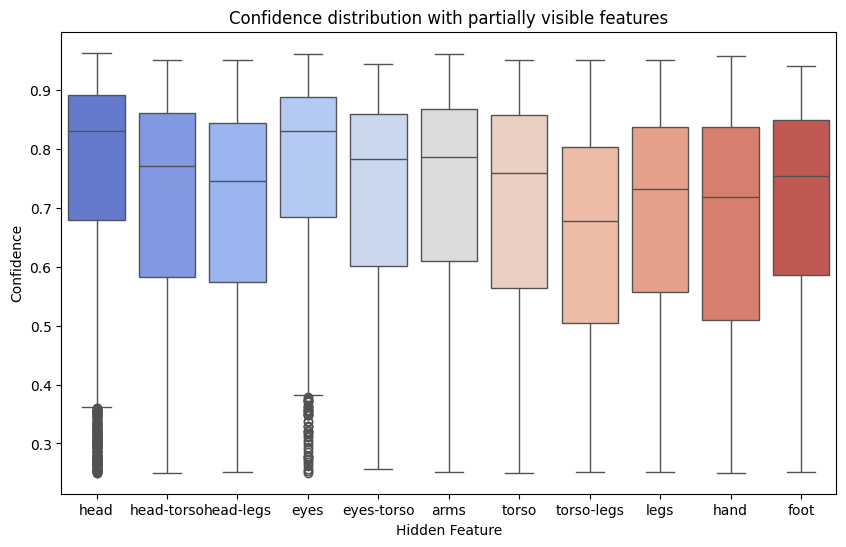

In [524]:
partially_visible_parts_df = create_not_visible_df(result_df, partial=True)
plot_df = pd.concat(partially_visible_parts_df, axis=0)

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Feature', y='Confidence', palette='coolwarm')

plt.title("Confidence distribution with partially visible features")
plt.xlabel("Hidden Feature")
plt.ylabel("Confidence")
plt.show()

## Missing attributes in hidden features

In [550]:
result_df

ID     Img  person_num  area_norm  img_width  img_height  \
0       3918950  391895           1   0.061229        640         360   
1       3918951  391895           2   0.003074        640         360   
2       5224180  522418           1   0.206137        640         480   
3       3182190  318219           1   0.356520        556         640   
4       3182191  318219           2   0.129390        556         640   
...         ...     ...         ...        ...        ...         ...   
190035  4755461  475546           2   0.020543        500         375   
190036  4755462  475546           3   0.027195        500         375   
190037  4755463  475546           4   0.030041        500         375   
190038  4755464  475546           5   0.133008        500         375   
190039  4755465  475546           6   0.006255        500         375   

               x         y     width    height  foot  legs  arms  eyes  head  \
0       0.531062  0.061556  0.240437  0.835361   1.0   1.0  0.50  0.50   0.5   
1       0.736938  0.480056  0.056125  0.133611   0.0   0.0  0.00  0.00   0.0   
2       0.597625  0.000000  0.401250  0.988146   0.0   0.0  0.50  0.50   0.6   
3       0.073112  0.060625  0.752482  0.939375   0.0   0.0  1.00  0.50   0.6   
4       0.000000  0.000000  0.357770  0.986484   0.0   0.0  0.50  0.25   0.3   
...          ...       ...       ...       ...   ...   ...   ...   ...   ...   
190035  0.823240  0.369253  0.146540  0.245493   0.0   0.0  1.00  1.00   0.8   
190036  0.415600  0.351440  0.164900  0.275573   0.0   0.0  0.75  1.00   1.0   
190037  0.221280  0.369360  0.179060  0.277040   0.0   0.0  1.00  1.00   1.0   
190038  0.000000  0.258427  0.259560  0.730347   0.0   0.0  0.00  0.00   0.2   
190039  0.949520  0.423093  0.050480  0.184880   0.0   0.0  0.00  0.00   0.0   

        hand  torso  
0       0.50  1.000  
1       0.00  0.000  
2       0.00  0.250  
3       0.50  1.000  
4       0.50  0.500  
...      ...    ...  
190035  0.00  1.000  
190036  0.50  0.875  
190037  0.00  0.875  
190038  0.75  0.500  
190039  0.25  0.750  

[190040 rows x 17 columns]

In [551]:
t_df1 = single_anns_df[single_anns_df['Img'].isin(set(all_predictions_df['Img_ID']))]

t_df2 = result_df[['ID', 'Img']]

merged_df = pd.merge(t_df1, t_df2, on=['ID', 'Img'], how='left', indicator=True)

diff = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
